# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns                    # noqa
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
import pickle
import shap
import joblib
from statannot.statannot import add_stat_annotation
from CULPRIT_utils import load_CULPRIT_data, get_features, get_data_from_features

/home/nnieto/Nico/MODS_project/Heart_env/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/nnieto/Nico/MODS_project/Heart_env/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def d

ModuleNotFoundError: No module named 'CULPRIT_utils'

# Figure 1

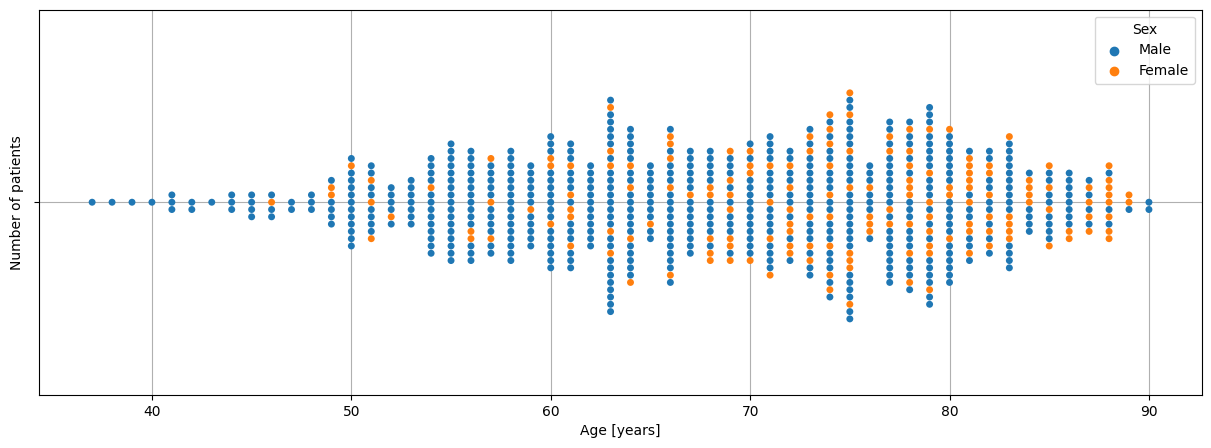

In [2]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/CULPRIT_data/202302_Jung/" # noqa
# endpoint to use
endpoint_to_use = "fu_ce_death_le30d_yn"    # or "fu_ce_death_le365d_yn"

# Get different features depending on the model
# Get all data
patient_info, lab_info, clip_info = load_CULPRIT_data(data_dir)
# Set target
y = patient_info.loc[:, ["patient_ID", endpoint_to_use]]


# Extract all the 24hs available features
exp_name = "24hs"
patient_features, lab_features, clip_features = get_features(exp_name)

data, features_24 = get_data_from_features(patient_info, lab_info,
                                           clip_info,
                                           patient_features,
                                           lab_features,
                                           clip_features)

patient_measures = data
patient_measures.rename(columns={"had_dem_age_yr": "Age"}, inplace=True)

patient_measures.rename(columns={"had_dem_male_yn": "Sex"}, inplace=True)
patient_measures["Sex"].replace({1: "Male", 0: "Female"}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=[15, 5])

sns.swarmplot(data=patient_measures, x="Age", hue="Sex",
              ax=ax)
plt.xlabel("Age [years]")
plt.grid(["x"])
plt.ylabel("Number of patients")
plt.show()

# Fig complementary to Shap Smokers

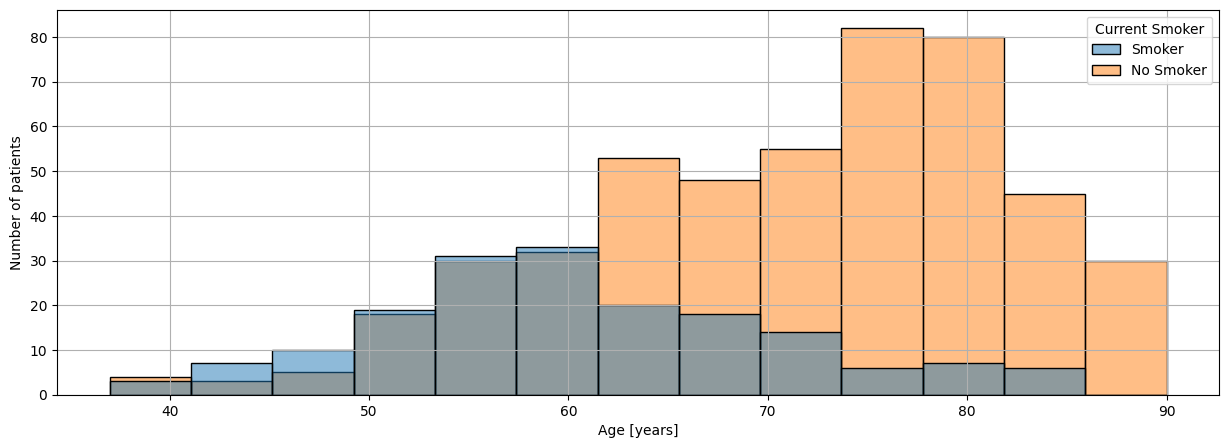

In [4]:
patient_measures.rename(columns={"had_dem_male_yn": "Sex"}, inplace=True)
patient_measures["Sex"].replace({1: "Male", 0: "Female"}, inplace=True)
patient_measures.rename(columns={"p_rf_smoker_yn": "Current Smoker"},
                        inplace=True)

fig, ax = plt.subplots(1, 1, figsize=[15, 5])
patient_measures["Current Smoker"].replace({1: "Smoker", 0: "No Smoker"},
                                           inplace=True)

sns.histplot(data=patient_measures, x="Age", hue="Current Smoker")

plt.xlabel("Age [years]")
plt.grid(["x"])
plt.ylabel("Number of patients")
plt.show()

# Figure 2

In [16]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
# Load the scores
results_df = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels.csv", index_col=0)
results_df = results_df[results_df["Model"] != "Cascade_Risk"]
results_df = results_df[results_df["Model"] != "Combined"]

results_df = results_df[results_df["Model"] != "Cascade_NoRisk"]
results_df = results_df[results_df["Model"] != "CLIP_SCORE"]
results_df = results_df[results_df["Model"] != "Admission"]
results_df = results_df[results_df["Model"] != "24hs"]
results_df = results_df[results_df["Model"] != "Combined_only_risk_cascade"]
results_df = results_df[results_df["Model"] != "Combined_only_norisk_cascade"]


results_df_CLIP = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels_CLIP.csv", index_col=0)
results_df = pd.concat([results_df, results_df_CLIP])
results_df["Model"].unique()

results_df.to_csv(data_dir+ "metrics_10x10_true_and_random_labels_scores.csv")

In [14]:
results_df_CLIP = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels_CLIP.csv", index_col=0)

results_df_CLIP.head()

,Fold,Model,Random State,Random Permutation,Balanced ACC,AUC,F1,Specificity,Sensitivity
0,0,CLIP_SCORE,True,0,0.50000,0.210526,0.00000,1.0,0.0000
1,1,CLIP_SCORE,True,0,0.50000,0.796791,0.00000,1.0,0.0000
2,2,CLIP_SCORE,True,0,0.50000,0.775000,0.00000,1.0,0.0000
3,3,CLIP_SCORE,True,0,0.65625,0.817500,0.47619,1.0,0.3125
4,4,CLIP_SCORE,True,0,0.50000,0.228833,0.00000,1.0,0.0000


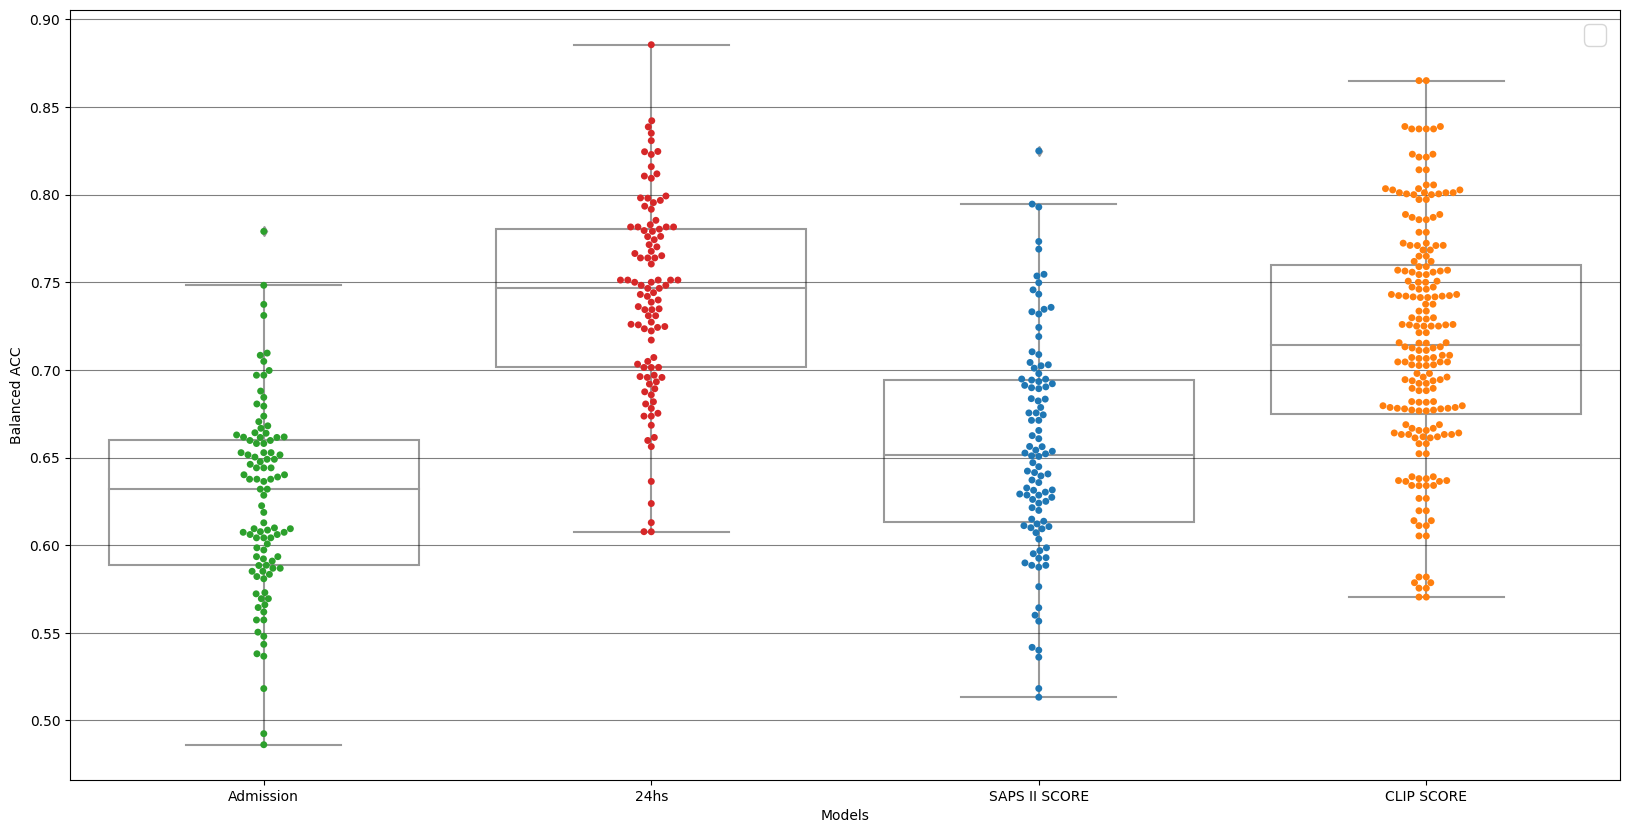

In [17]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
# Load the score results
results_df = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels_scores.csv", index_col=0)
# Load the scores from the high variance features
results_df_hv = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels_high_variance.csv", index_col=0)
# put all together
results_df = pd.concat([results_df, results_df_CLIP, results_df_hv])
# Change Naming
results_df["Model"].replace({"SAPS_SCORE": "SAPS II SCORE",
                             "CLIP_SCORE": "CLIP SCORE",
                             "IABP_SCORE": "IABP II SCORE"}, inplace=True)

results_true_label = results_df[results_df["Random State"]== False]

metric_to_plot = "Balanced ACC"

models_to_plot = [
                "Admission",
                  "24hs",
                  "SAPS II SCORE", 
                  "CLIP SCORE"]

filtered_df = results_true_label[results_true_label['Model'].isin(models_to_plot)]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])

n_models = results_true_label["Model"].nunique()

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


sns.swarmplot(
    data=filtered_df,
    x="Model", y=metric_to_plot,
    order=models_to_plot, 
    dodge=False, hue="Model", ax=ax,
)

sns.boxplot(
    data=filtered_df, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    order=models_to_plot,
    dodge=True, ax=ax, palette=["w"]*n_models
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:models_to_plot.__len__()], labels[:models_to_plot.__len__()])
ax.legend([])

plt.ylabel(metric_to_plot)
plt.xlabel("Models")
# plt.title(metric_to_plot + " in CULPRIT dataset")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

# Table Results Summary

In [18]:
results_true_label = results_df[results_df["Random State"]== False]


models_to_plot = ["Admission",
                  "24hs",
                  "SAPS II SCORE",
                  "CLIP SCORE", 
                  ]

metrics = ["Balanced ACC",
           "AUC",
           "F1",
           "Specificity",
           "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(results_true_label[results_true_label["Model"] == model][metric].mean(),3)
        results_std = round(results_true_label[results_true_label["Model"] == model][metric].std(),3)
        print(metric + ": " + str(results_mean) + " +- " + str(results_std))
        confidence_interval = stats.t.interval(0.95, len(results_true_label[results_true_label["Model"] == model][metric]) - 1, loc=results_mean, scale=results_std)
        print("95% Confidence Interval: [", str(round(confidence_interval[0],3)) + "-" + str(round(confidence_interval[1],3))+"]")


Admission
Balanced ACC: 0.626 +- 0.053
95% Confidence Interval: [ 0.521-0.731]
AUC: 0.677 +- 0.066
95% Confidence Interval: [ 0.546-0.808]
F1: 0.602 +- 0.06
95% Confidence Interval: [ 0.483-0.721]
Specificity: 0.654 +- 0.082
95% Confidence Interval: [ 0.491-0.817]
Sensitivity: 0.598 +- 0.078
95% Confidence Interval: [ 0.443-0.753]
24hs
Balanced ACC: 0.742 +- 0.055
95% Confidence Interval: [ 0.633-0.851]
AUC: 0.834 +- 0.045
95% Confidence Interval: [ 0.745-0.923]
F1: 0.725 +- 0.062
95% Confidence Interval: [ 0.602-0.848]
Specificity: 0.765 +- 0.069
95% Confidence Interval: [ 0.628-0.902]
Sensitivity: 0.718 +- 0.084
95% Confidence Interval: [ 0.551-0.885]
SAPS II SCORE
Balanced ACC: 0.656 +- 0.062
95% Confidence Interval: [ 0.533-0.779]
AUC: 0.693 +- 0.074
95% Confidence Interval: [ 0.546-0.84]
F1: 0.596 +- 0.079
95% Confidence Interval: [ 0.439-0.753]
Specificity: 0.756 +- 0.074
95% Confidence Interval: [ 0.609-0.903]
Sensitivity: 0.556 +- 0.094
95% Confidence Interval: [ 0.369-0.743]
C

# Figure 3

36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
65.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


p-value annotation legend:
ns: 1.00e-03 < p <= 1.00e+00
*p<0.001: p <= 1.00e-03

SAPS II SCORE_False v.s. SAPS II SCORE_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.589e-35 U_stat=9.948e+03


43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
68.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


Admission_False v.s. Admission_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.519e-26 U_stat=9.368e+03


68.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


24hs_False v.s. 24hs_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.663e-33 U_stat=9.968e+03


68.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


CLIP SCORE_False v.s. CLIP SCORE_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.137e-69 U_stat=3.956e+04


68.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
68.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
68.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


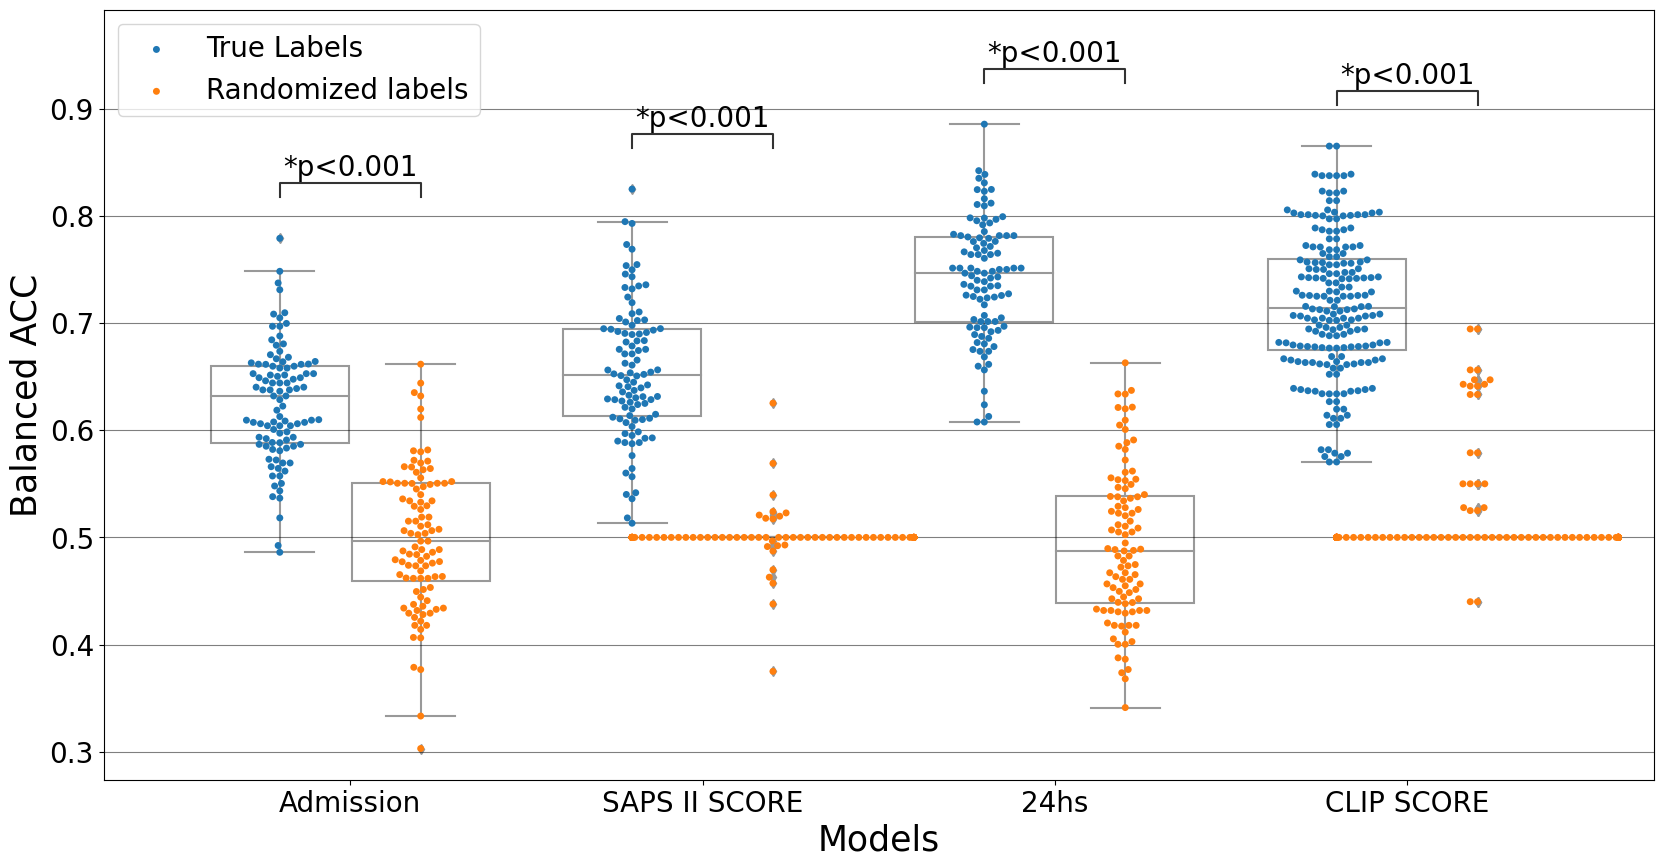

In [19]:
# THE DATA IS SET IN THE PREVIUS CELL

models_to_plot = ["Admission","SAPS II SCORE",
                #   "Cascade Risk", "Cascade No Risk",
                  "24hs", 
                  "CLIP SCORE"]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])
filtered_df = results_df[results_df['Model'].isin(models_to_plot)]

n_models = results_df["Model"].nunique()

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


metric_to_plot = "Balanced ACC"

sns.swarmplot(
    data=filtered_df,
    x="Model", y=metric_to_plot,
    order=models_to_plot, 
    dodge=True, hue="Random State", ax=ax,
)

sns.boxplot(
    data=filtered_df, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    order=models_to_plot, hue="Random State",
    dodge=True, ax=ax, palette=["w"]*n_models
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:models_to_plot.__len__()], labels[:models_to_plot.__len__()])
ax.legend(["True Labels", "Randomized labels"])



# Comparisons for statistical test
box_list = [(("Admission", True), ("Admission", False)),
            (("24hs", True), ("24hs", False)),
            (("SAPS II SCORE", True), ("SAPS II SCORE", False)),
            (("CLIP SCORE", True), ("CLIP SCORE", False))]


add_stat_annotation(ax, data=filtered_df, x="Model", y=metric_to_plot,
                    box_pairs=box_list, test='Mann-Whitney', hue="Random State",
                    text_format='star', loc='inside', order=models_to_plot,
                    verbose=1,
                    pvalue_thresholds=[[1, "ns"], [0.001, "*p<0.001"]])

plt.ylabel(metric_to_plot)
plt.xlabel("Models")
# plt.title(metric_to_plot + " in CULPRIT dataset")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

# Figure 4

The label '_none' of <matplotlib.collections.PolyCollection object at 0x7efcd3d49730> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7efcd3d09760> starts with '_'. It is thus excluded from the legend.


[]

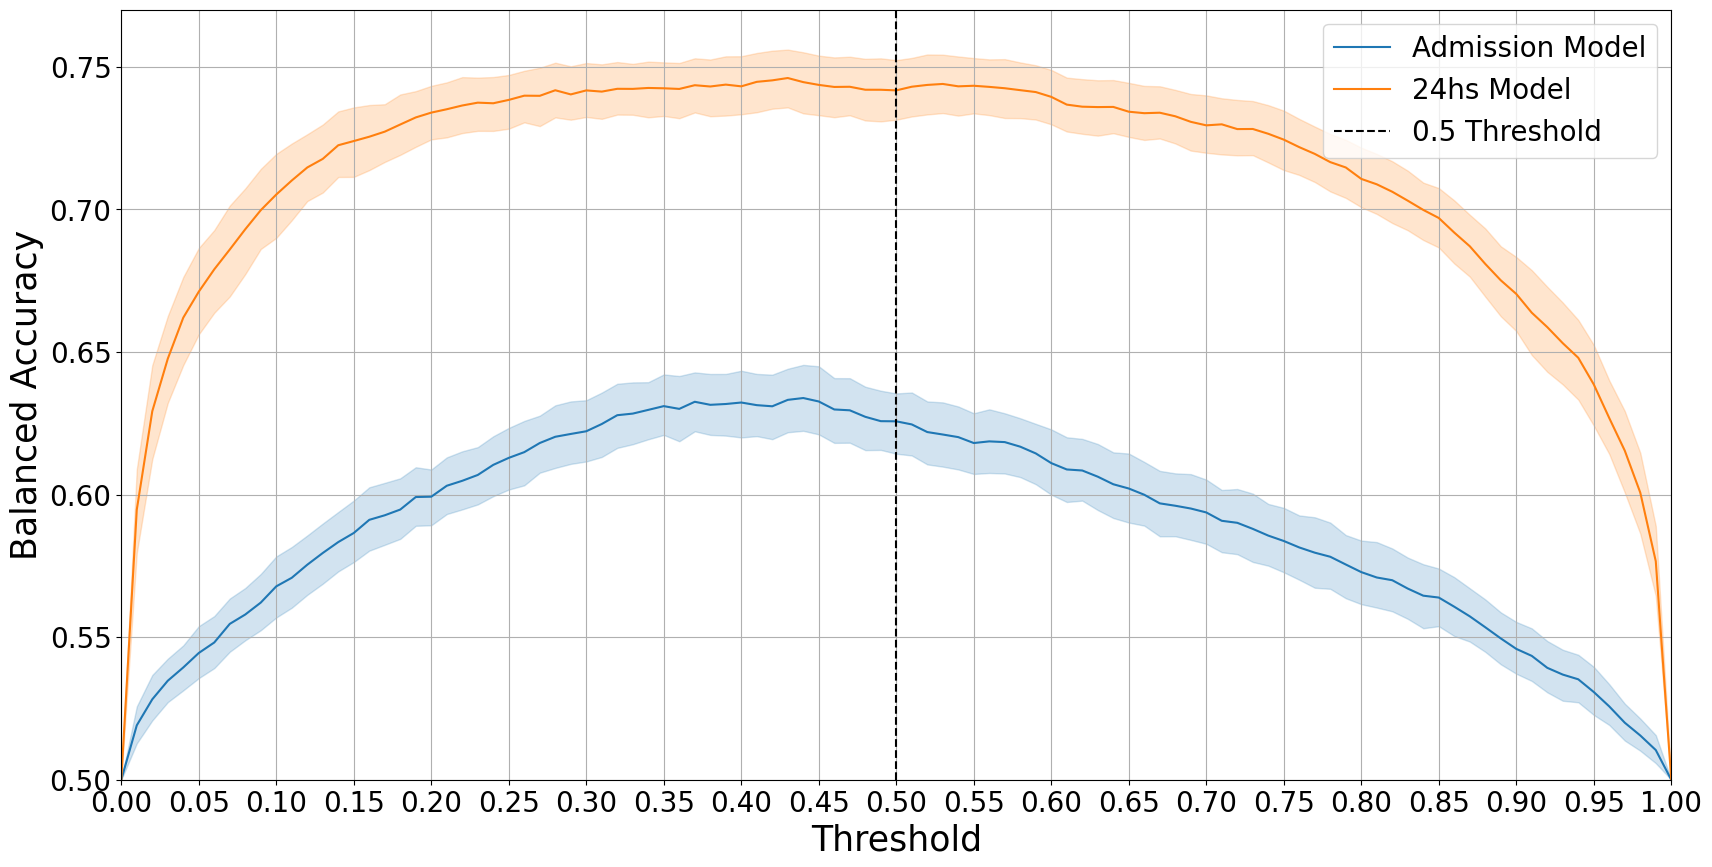

In [23]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
results_ths_df = pd.read_csv(data_dir + "threshold_10x10_all_models_high_variance.csv")

fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "Balanced ACC"
# model_to_plot = "Combined_only_norisk_cascade"

# results_ths_df_to_plot = results_ths_df[results_ths_df["Model"] == model_to_plot]   # noqa
# sns.lineplot(data=results_ths_df_to_plot, y=metric_to_plot, x="Threshold")
# model_to_plot = "Combined_only_risk_cascade"
# results_ths_df_to_plot = results_ths_df[results_ths_df["Model"] == model_to_plot]   # noqa
# sns.lineplot(data=results_ths_df_to_plot, y=metric_to_plot, x="Threshold")
model_to_plot = "Admission"
results_ths_df_to_plot = results_ths_df[results_ths_df["Model"] == model_to_plot]   # noqa
sns.lineplot(data=results_ths_df_to_plot, y=metric_to_plot, x="Threshold")
plt.ylabel("Performance")
model_to_plot = "24hs"
results_ths_df_to_plot = results_ths_df[results_ths_df["Model"] == model_to_plot]   # noqa
sns.lineplot(data=results_ths_df_to_plot, y=metric_to_plot, x="Threshold")
ths = 0.5

sns.lineplot(x=[ths-.00000001, ths+.00000001], y=[0.50, .8], ax=ax, color="black", linestyle="--", legend=True)
plt.ylim([0.5,0.77])
plt.xlim([0,1])
plt.ylabel("Balanced Accuracy")
plt.title("")
plt.grid()


plt.legend(["Admission Model", "_none", "24hs Model", "_none", "0.5 Threshold"])
custom_ticks = np.arange(0, 1.01, 0.05)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
plt.plot()

# Missing Values analysis 24hs

## Direct order


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7efcd38f1670> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.lines.Line2D object at 0x7efcd38ae070> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7efcd38ae8b0> starts with '_'. It is thus excluded from the legend.


[]

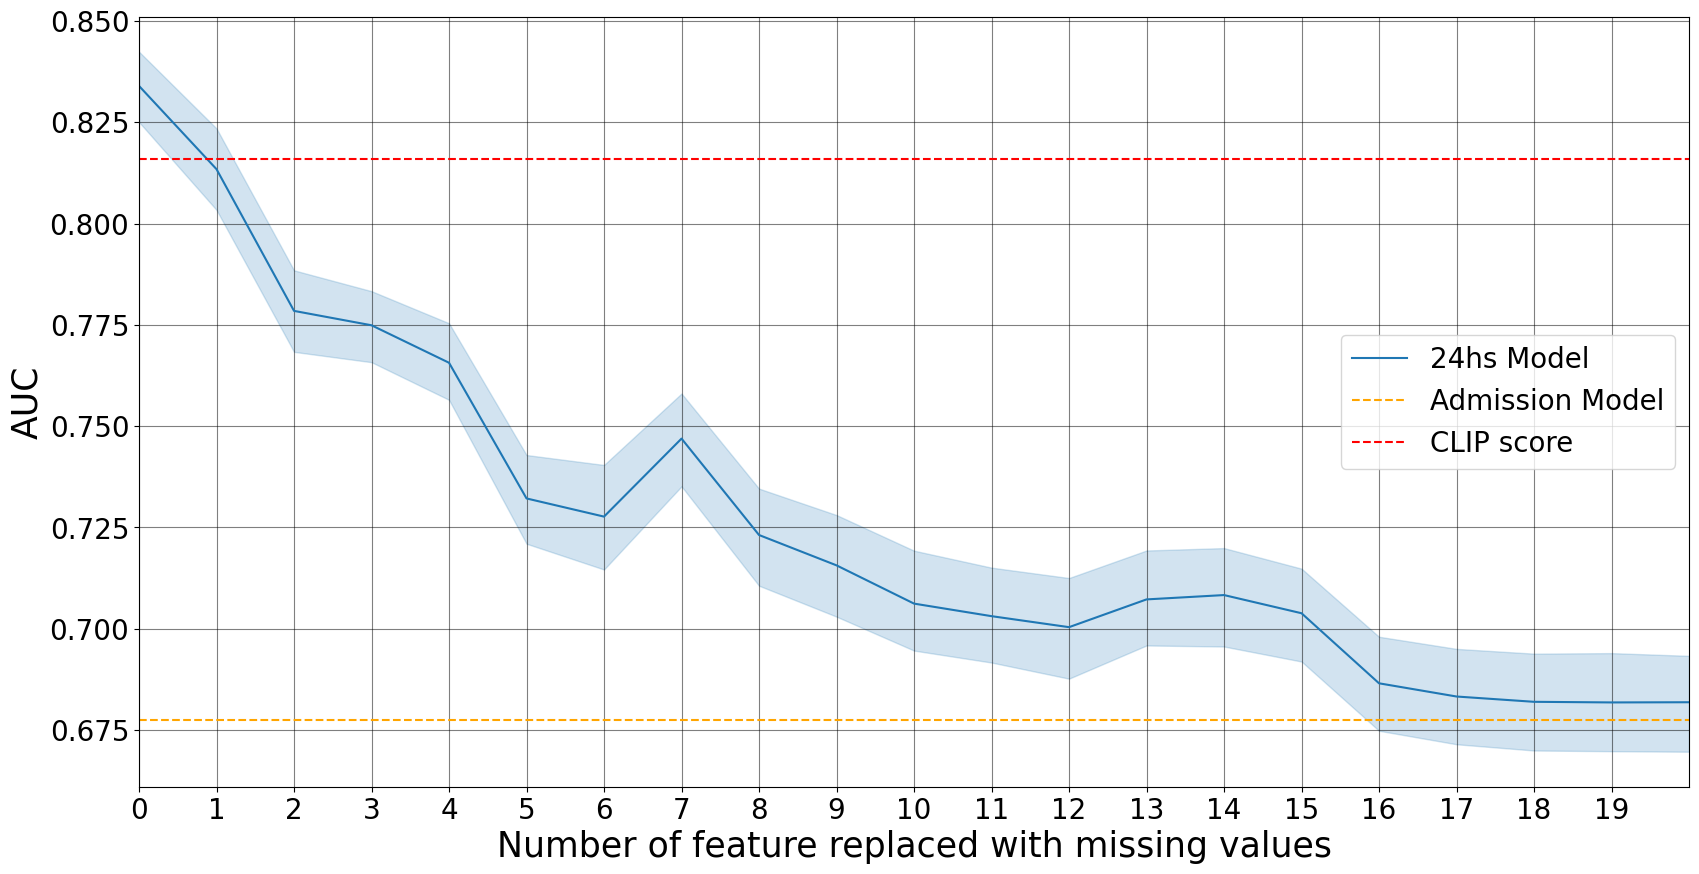

In [29]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/missing_values/"
results_mv = pd.read_csv(data_dir + "missing_values_10foldx10rep_high_variance_direct_importance.csv")
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
# Load the scores from the high variance features
results_df_hv = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels_high_variance.csv", index_col=0)
results_df_hv = results_df_hv[results_df_hv["Random State"]== False]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "AUC"

# Change the feature name with a number
results_mv_to_plot = results_mv[results_mv["Model"] == "24hs"]
for i, feature in enumerate(results_mv_to_plot["Percenage_nan"].unique()):
   results_mv_to_plot["Percenage_nan"].replace({feature: i},inplace=True)
   
sns.lineplot(
    data=results_mv_to_plot,
    x="Percenage_nan", y=metric_to_plot,
    hue="Model", ax=ax
)
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



admission_mean = results_df_hv[results_df_hv["Model"] == "Admission"][metric_to_plot].mean()
sns.lineplot(
    x=[0, 100],
    y=admission_mean,
    ax=ax, legend=True, color="orange", linestyle="--")
plt.grid(alpha=0.5, c="black")
plt.xlim([0,20])

sns.lineplot(
    x=[0, 100],
    y=0.816,
    ax=ax, legend=True, color="red", linestyle="--")
plt.grid(alpha=0.5, c="black")
plt.xlim([0,20])

plt.legend(["24hs Model","_none", "_none", "Admission Model", "_none", "CLIP score"])
plt.xlabel("Number of feature replaced with missing values")
custom_ticks = np.arange(0, 20, 1)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
plt.plot()

## Inverse order

The label '_none' of <matplotlib.collections.PolyCollection object at 0x7efcd35b2b20> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.lines.Line2D object at 0x7efcd3574d60> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7efcd357aee0> starts with '_'. It is thus excluded from the legend.


[]

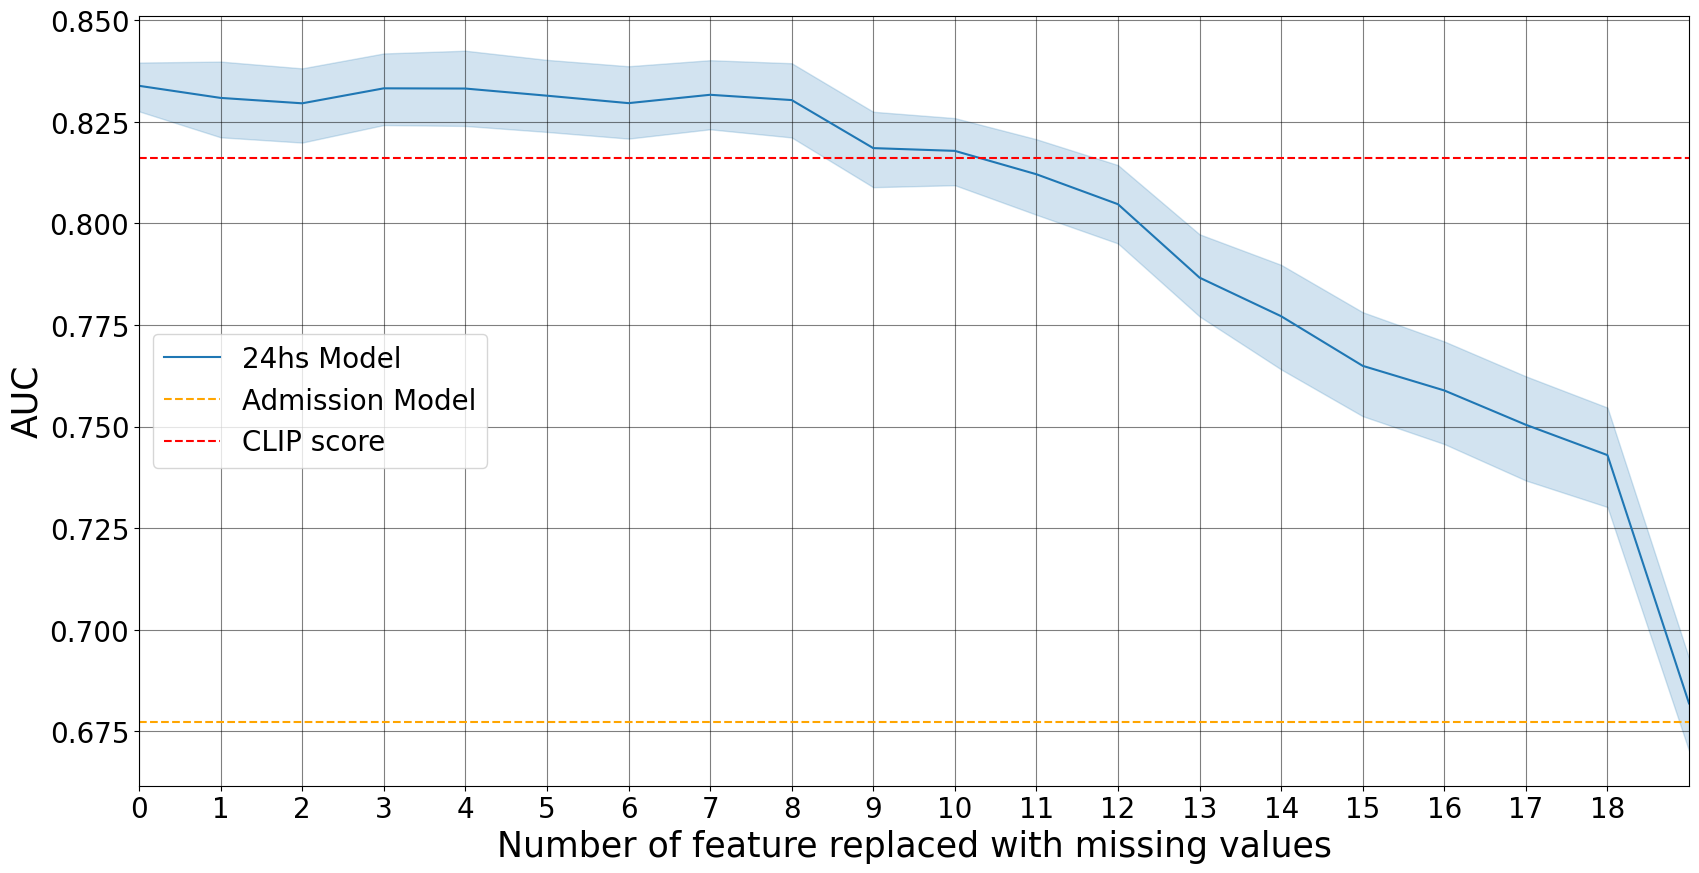

In [33]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/missing_values/"
results_mv = pd.read_csv(data_dir + "missing_values_10foldx10rep_high_variance_inverse_importance.csv")
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
# Load the scores from the high variance features
results_df_hv = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels_high_variance.csv", index_col=0)
results_df_hv = results_df_hv[results_df_hv["Random State"]== False]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "AUC"

# Change the feature name with a number
results_mv_to_plot = results_mv[results_mv["Model"] == "24hs"]
for i, feature in enumerate(results_mv_to_plot["Percenage_nan"].unique()):
   results_mv_to_plot["Percenage_nan"].replace({feature: i},inplace=True)
   
sns.lineplot(
    data=results_mv_to_plot,
    x="Percenage_nan", y=metric_to_plot,
    hue="Model", ax=ax
)
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



admission_mean = results_df_hv[results_df_hv["Model"] == "Admission"][metric_to_plot].mean()
sns.lineplot(
    x=[0, 100],
    y=admission_mean,
    ax=ax, legend=True, color="orange", linestyle="--")
plt.grid(alpha=0.5, c="black")
plt.xlim([0,20])

sns.lineplot(
    x=[0, 100],
    y=0.816,
    ax=ax, legend=True, color="red", linestyle="--")
plt.grid(alpha=0.5, c="black")
plt.xlim([0,19])

plt.legend(["24hs Model","_none", "_none", "Admission Model", "_none", "CLIP score"])
plt.xlabel("Number of feature replaced with missing values")
custom_ticks = np.arange(0, 19, 1)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
plt.plot()

## Random Order

The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f471191af10> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.lines.Line2D object at 0x7f47111ebd60> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f470afce790> starts with '_'. It is thus excluded from the legend.


Text(0.5, 1.0, '24hs Model - Missing values experiment')

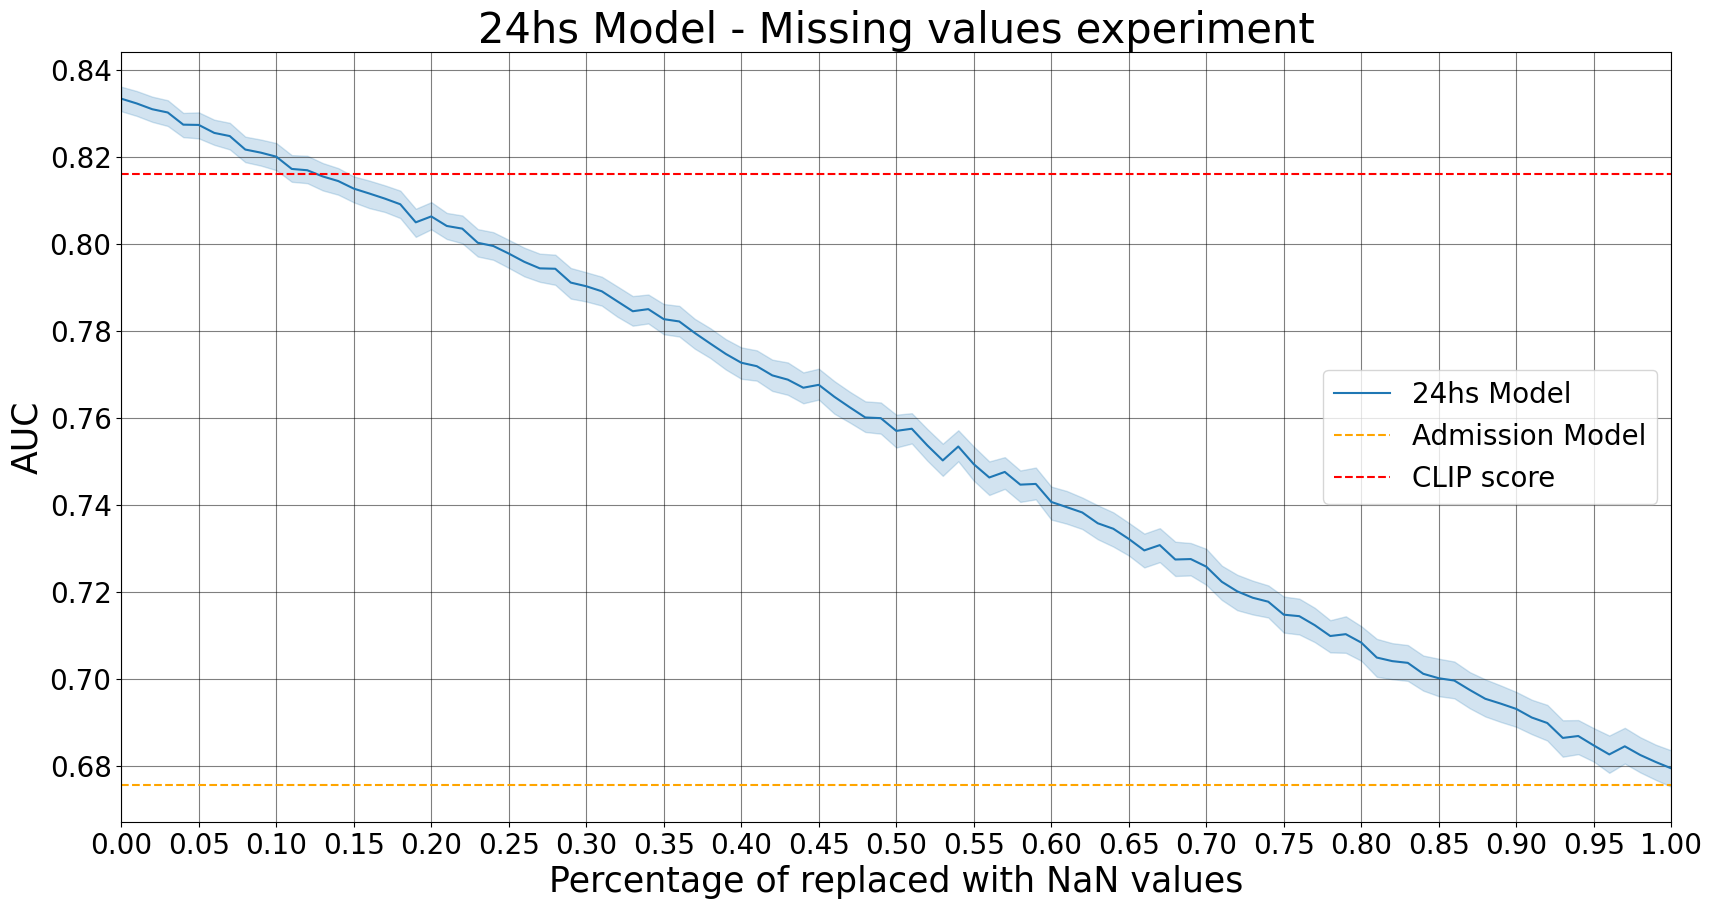

In [166]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
results_mv = pd.read_csv(data_dir + "missing_values_10foldx10repx10shuffle.csv")
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "AUC"


results_mv_to_plot = results_mv[results_mv["Model"] == "24hs"]
sns.lineplot(
    data=results_mv_to_plot,
    x="Percenage_nan", y=metric_to_plot,
    hue="Model", ax=ax
)

admission_mean = results_mv[results_mv["Model"] == "Admission"][metric_to_plot].mean()
sns.lineplot(
    x=[0, 1],
    y=admission_mean,
    ax=ax, legend=True, color="orange", linestyle="--",)
plt.grid(alpha=0.5, c="black")


sns.lineplot(
    x=[0, 1],
    y=0.816,
    ax=ax, legend=True, color="red", linestyle="--")
plt.grid(alpha=0.5, c="black")
# plt.xlim([0,45])

plt.legend(["24hs Model","_none", "_none", "Admission Model", "_none", "CLIP score"])
# Set custom x-axis ticks and labels
import numpy as np
custom_ticks = np.arange(0, 1.01, 0.05)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
plt.xlim([0,1])
plt.xlabel("Percentage of replaced with NaN values")
plt.title("24hs Model - Missing values experiment")

Text(0.5, 0, 'Percentage of replaced with NaN values')

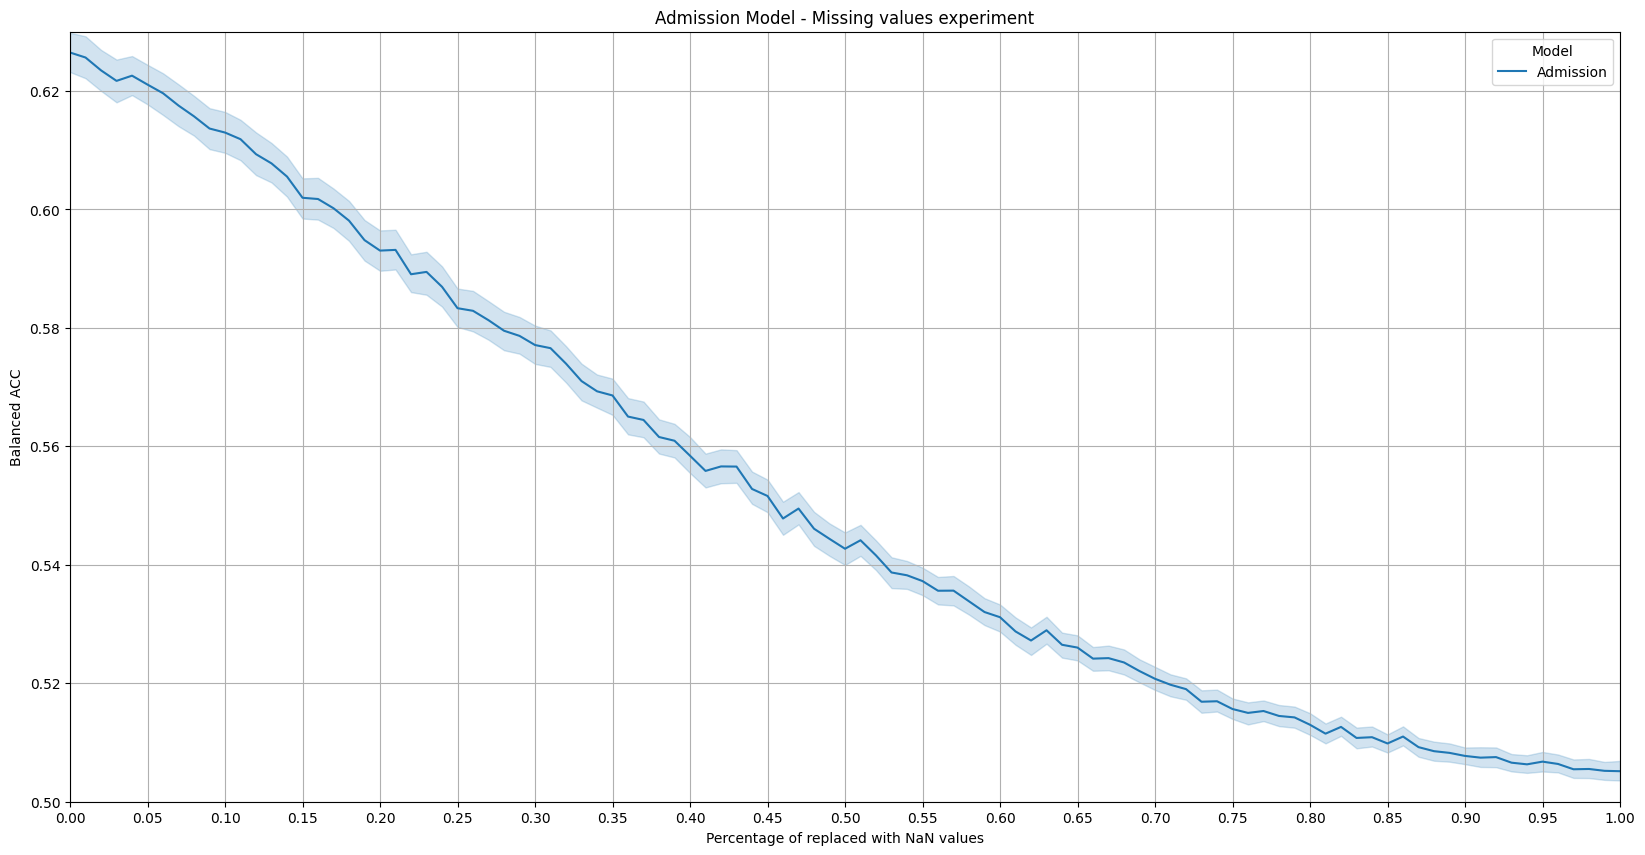

In [13]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
results_df = pd.read_csv(data_dir+ "admission_missing_values_10foldx10repx10shuffle.csv")   # noqa
# %%
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "Balanced ACC"
sns.lineplot(
    data=results_df,
    x="Percenage_nan", y=metric_to_plot,
    hue="Model", ax=ax
)
plt.grid()
custom_ticks = np.arange(0, 1.01, 0.05)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
plt.xlim([0, 1])
plt.ylim([0.5, 0.63])
plt.title("Admission Model - Missing values experiment")
plt.xlabel("Percentage of replaced with NaN values")


# Using features importance


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f38cb46da30> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.lines.Line2D object at 0x7f38cb481ca0> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f38cb430190> starts with '_'. It is thus excluded from the legend.


Text(0.5, 0, 'Number of feature replaced with missing values')

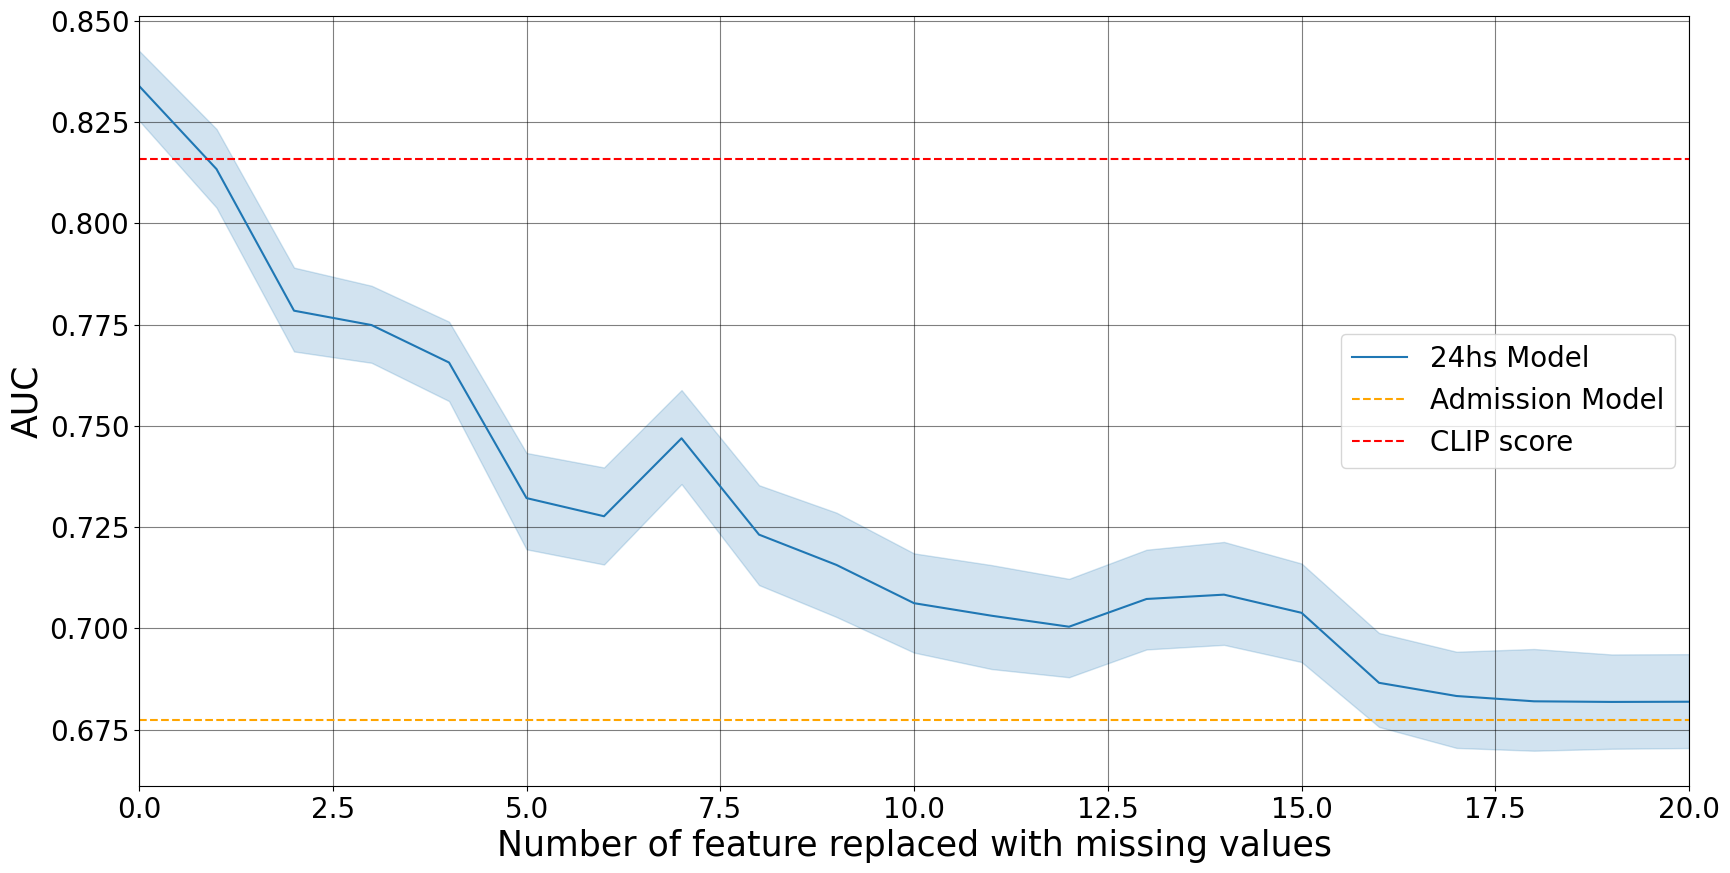

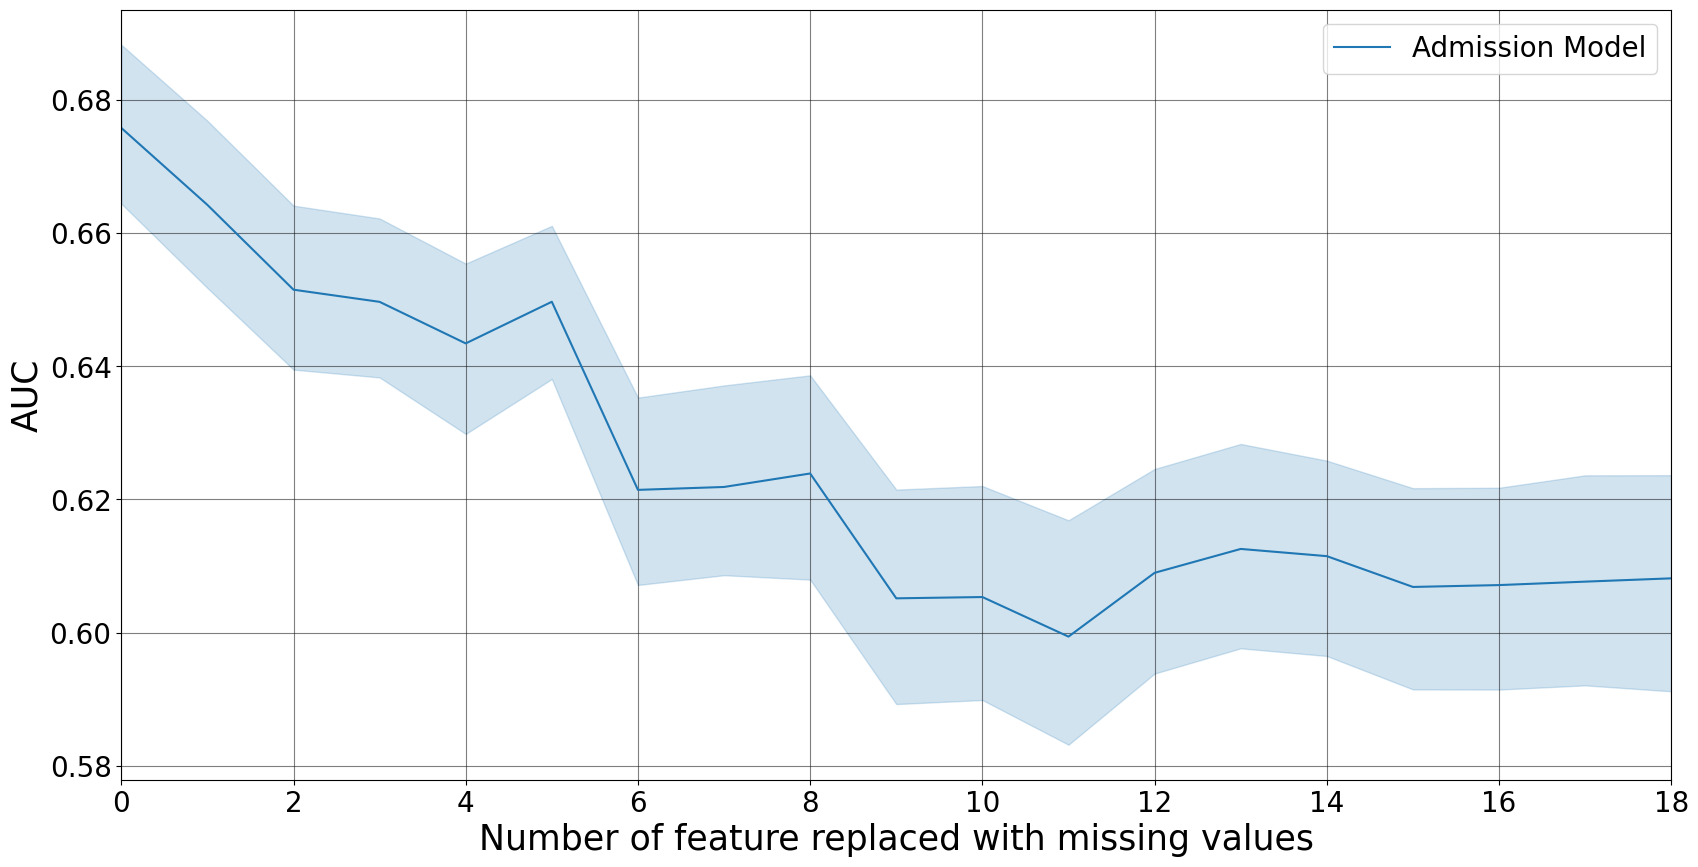

In [8]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
results_mv = pd.read_csv(data_dir + "admission_missing_values_10foldx10rep_importace_inverse.csv")
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "AUC"
results_mv_to_plot = results_mv[results_mv["Model"] == "Admission"]
for i, feature in enumerate(results_mv_to_plot["Percenage_nan"].unique()):
   results_mv_to_plot["Percenage_nan"].replace({feature: i},inplace=True)
   
sns.lineplot(
    data=results_mv_to_plot,
    x="Percenage_nan", y=metric_to_plot,
    hue="Model", ax=ax
)

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.grid(alpha=0.5, c="black")

plt.xlim([0,18])

plt.legend(["Admission Model"])
plt.xlabel("Number of feature replaced with missing values")
# plt.title("24hs Model - Adding missing values to less important feature")
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f4479f3e820> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.lines.Line2D object at 0x7f4479f54e80> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f4479ee1790> starts with '_'. It is thus excluded from the legend.


Text(0.5, 0, 'Number of feature replaced with missing values')

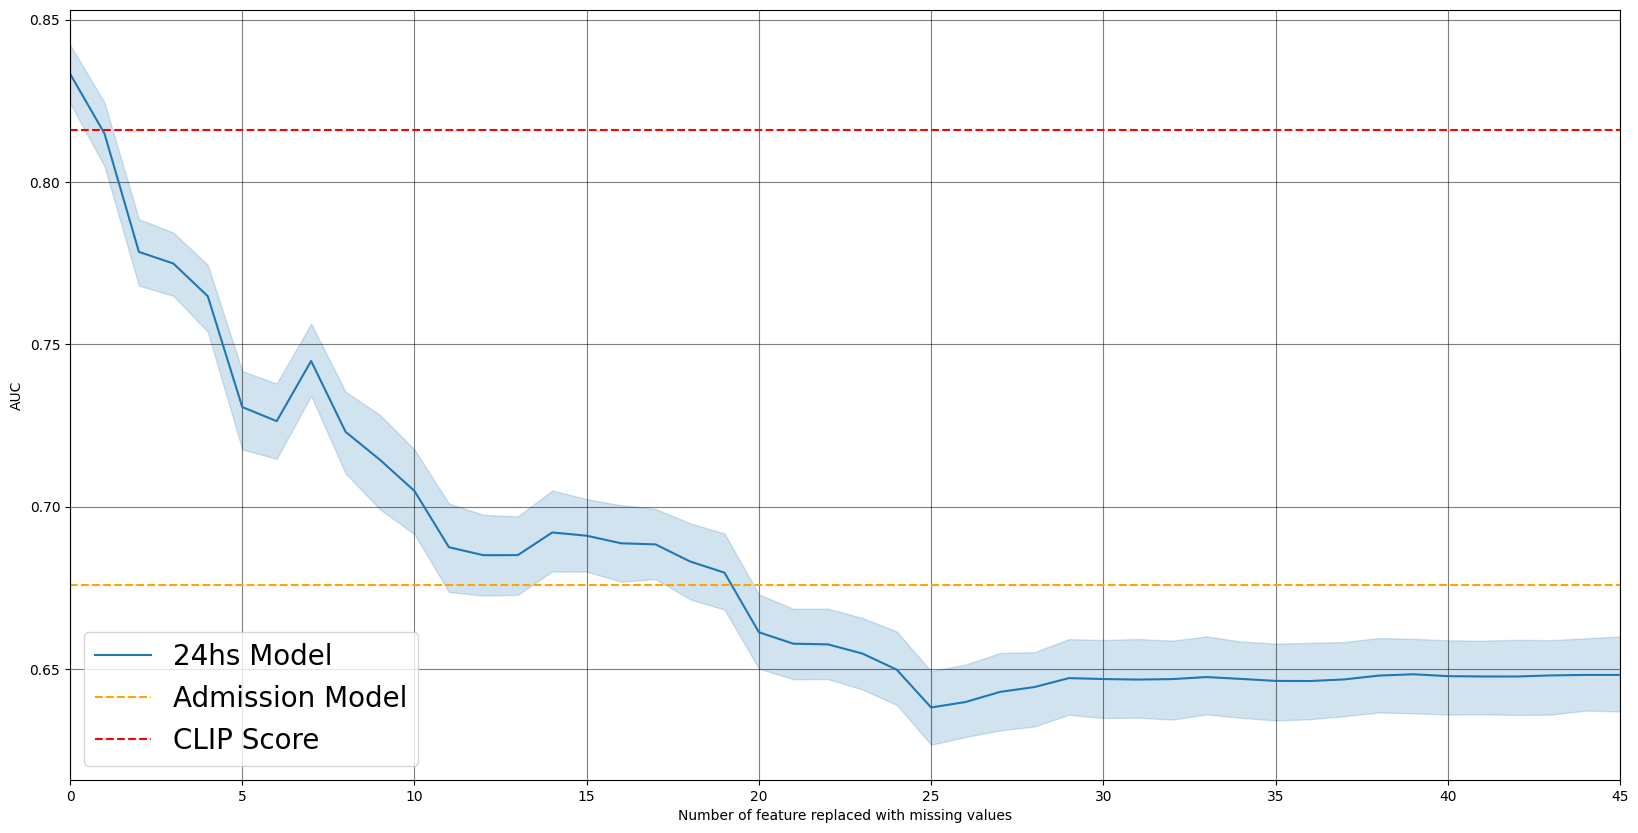

In [4]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
results_mv = pd.read_csv(data_dir + "missing_values_10foldx10rep_importance_inverse.csv")
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "AUC"

results_mv_to_plot = results_mv[results_mv["Model"] == "24hs"]
for i, feature in enumerate(results_mv_to_plot["Percenage_nan"].unique()):
   results_mv_to_plot["Percenage_nan"].replace({feature: i},inplace=True)
   
sns.lineplot(
    data=results_mv_to_plot,
    x="Percenage_nan", y=metric_to_plot,
    hue="Model", ax=ax
)
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

admission_mean = results_mv[results_mv["Model"] == "Admission"][metric_to_plot].mean()
sns.lineplot(
    x=[0, 100],
    y=admission_mean,
    ax=ax, legend=True, color="orange", linestyle="--")
plt.grid(alpha=0.5, c="black")
plt.xlim([0,45])
sns.lineplot(
    x=[0, 100],
    y=0.816,
    ax=ax, legend=True, color="red", linestyle="--")
plt.grid(alpha=0.5, c="black")
plt.xlim([0,45])
plt.legend(["24hs Model","_none", "_none", "Admission Model", "_none", "CLIP Score"])
plt.xlabel("Number of feature replaced with missing values")
# plt.title("24hs Model - Adding missing values to less important feature")

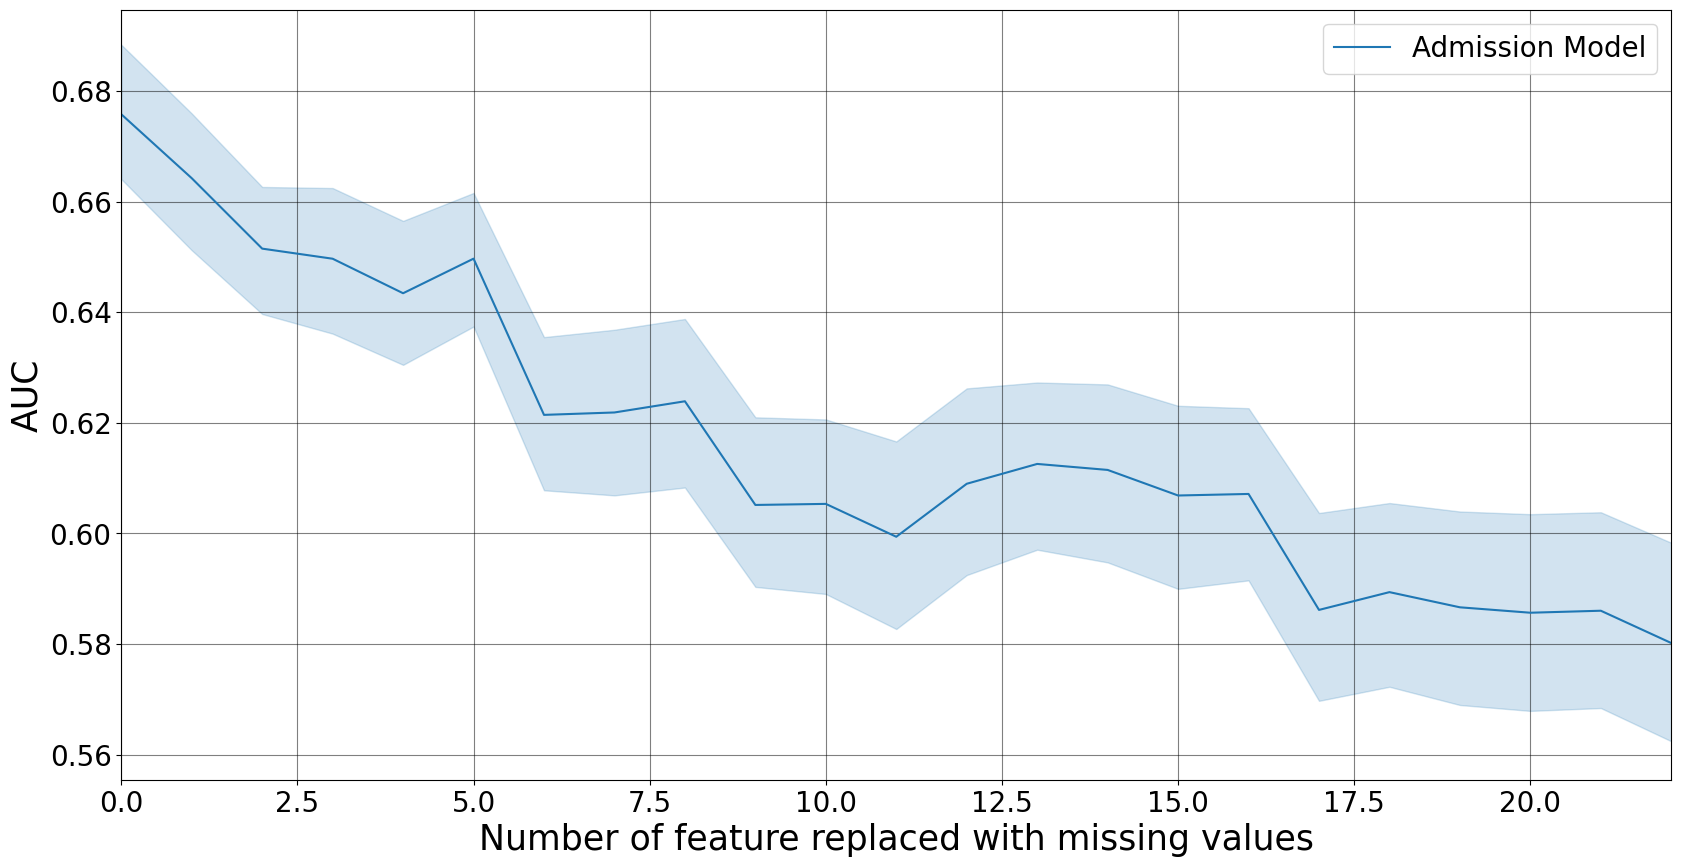

In [154]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
results_mv = pd.read_csv(data_dir + "admission_missing_values_10foldx10rep_importace_inverse.csv")
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "AUC"
results_mv_to_plot = results_mv[results_mv["Model"] == "Admission"]
for i, feature in enumerate(results_mv_to_plot["Percenage_nan"].unique()):
   results_mv_to_plot["Percenage_nan"].replace({feature: i},inplace=True)
   
sns.lineplot(
    data=results_mv_to_plot,
    x="Percenage_nan", y=metric_to_plot,
    hue="Model", ax=ax
)

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.grid(alpha=0.5, c="black")

plt.xlim([0,22])

plt.legend(["Admission Model"])
plt.xlabel("Number of feature replaced with missing values")
# plt.title("24hs Model - Adding missing values to less important feature")
plt.show()

# Number of estimators

/tmp/ipykernel_116214/3405224508.py:15: UserWarning: The label '_none' of <matplotlib.lines.Line2D object at 0x7efff1637700> starts with '_'. It is thus excluded from the legend.
  ax.legend(["True labels", "_none", "_none", "Randomized labels"])
/tmp/ipykernel_116214/3405224508.py:15: UserWarning: The label '_none' of <matplotlib.collections.PathCollection object at 0x7efff16379a0> starts with '_'. It is thus excluded from the legend.
  ax.legend(["True labels", "_none", "_none", "Randomized labels"])


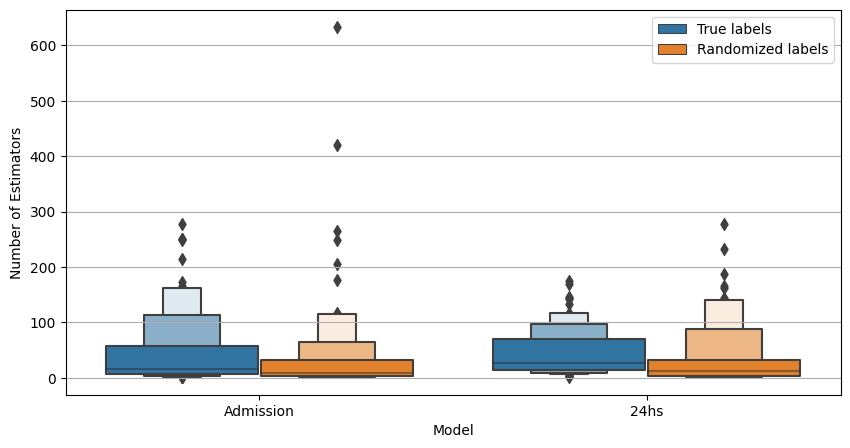

In [51]:
estimators_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"                # noqa
estimators = pd.read_csv(estimators_dir + "estimators_10x10_true_and_random_labels.csv")       # noqa
# %%

median_admission_estimators = round(estimators[estimators["Model"] == "Admission"]["Number of Estimators"].median())        # noqa
median_24hs_estimators = round(estimators[estimators["Model"] == "24hs"]["Number of Estimators"].median())                  # noqa
models_to_plot = ["Admission", "24hs"]

fig, ax = plt.subplots(1, 1, figsize=[10, 5])


sns.boxenplot(data=estimators, x="Model", y="Number of Estimators", hue="Random State", ax=ax,
              order=models_to_plot)
plt.grid(axis="y")
ax.legend(["True labels", "_none", "_none", "Randomized labels"])


# Shap values

## Admission Model

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


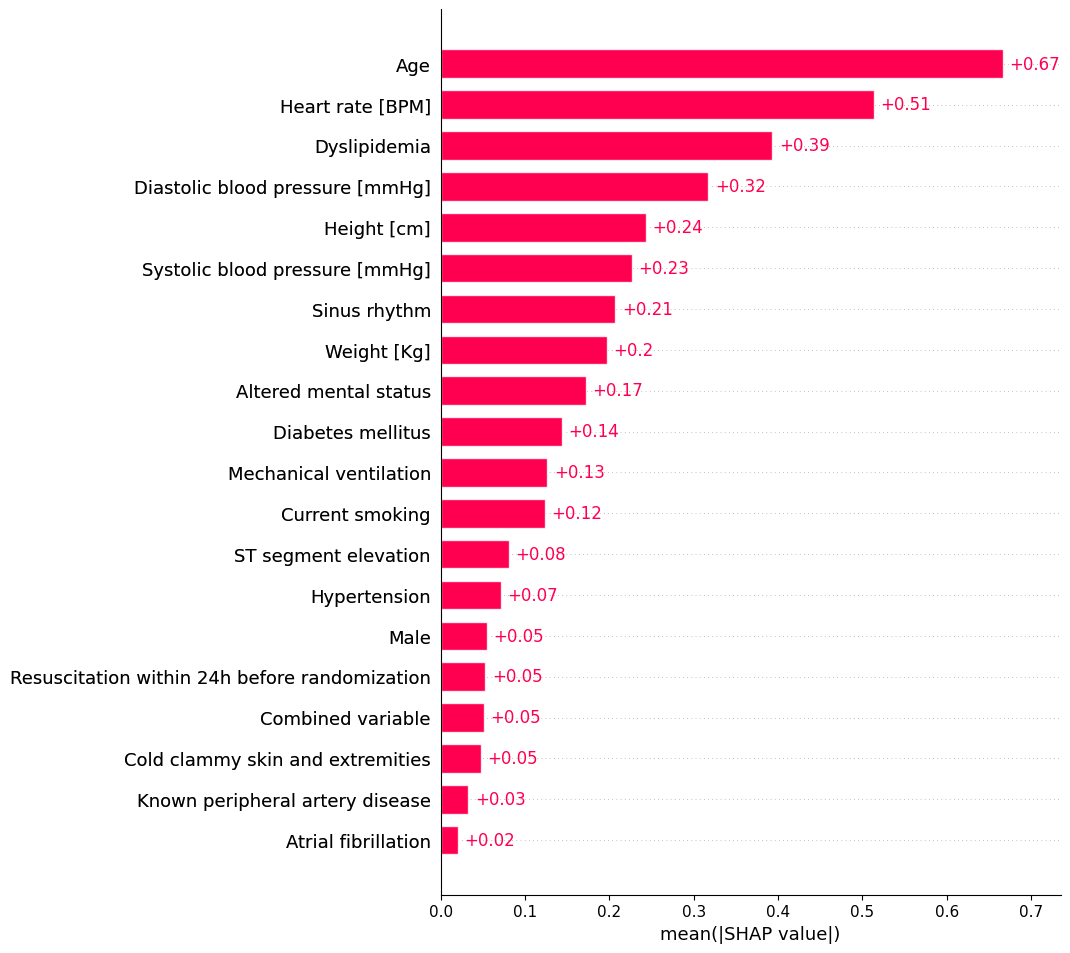

In [37]:

data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/shap_values/"
load_list = ["shap_admission_values",
             "shap_admission_baseline",
             "shap_admission_data",
             "shap_24hs_values",
             "shap_24hs_baseline",
             "shap_24hs_data"]

shap_dict = dict()

for file_name in load_list:
    with open(data_dir+file_name, "rb") as fp:
        shap_dict[file_name] = pickle.load(fp)
X_admission = pd.read_csv(data_dir+"X_admission_high_variance.csv",index_col=0)


X_admission.rename(columns={"Age_(year)": "Age",
                            "Heart_rate_(bpm)_Hemodinamics": "Heart rate [BPM]",
                            "Diastolic_blood_pressure_(mmHg)_–_HPR":"Diastolic blood pressure [mmHg]",
                            "Height_(cm)": "Height [cm]",
                            "Weight_(kg)": "Weight [Kg]",
                            'Mechanical_ventilation':'Mechanical ventilation',
                            "Resuscitation_within_24h_before_randomization": "Resuscitation within 24h before randomization",
                            "Altered_mental_status": "Altered mental status",
                            "Cold_clammy_skin_and_extremities": "Cold clammy skin and extremities",
                            "combined_variable": "Combined variable",
                            "Previous_congestive_heart_failure": "Previous congestive heart failure",
                            "Previous_stroke": "Previous stroke",
                            "Known_peripheral_artery_disease": "Known peripheral artery disease",
                            "Known_renal_insufficiency_(GFR_less_30_ml/min)": "Known renal insufficiency",
                            "Chronic_dialysis":"Chronic dialysis",
                            "Current_smoking": "Current smoking",
                            "Diabetes_mellitus": "Diabetes mellitus",
                            "Sinus_rhythm": "Sinus rhythm",
                            "Atrial_fibrillation": "Atrial fibrillation",
                            "AV-block_III": "AV block III",
                            'ST-segment_elevation':'ST segment elevation',
                            'Systolic_blood_pressure_(mmHg)_–_HPR':'Systolic blood pressure [mmHg]'}, inplace=True)



model = joblib.load(data_dir+"model_admission__shap_values_high_variance.pkl")

explainer = shap.Explainer(model)
shap_values = explainer(X_admission)

shap_values.values = shap_dict["shap_admission_values"]
shap_values.baseline = shap_dict["shap_admission_baseline"]
shap_values.data = shap_dict["shap_admission_data"]
shap.plots.bar(shap_values, max_display=28)

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


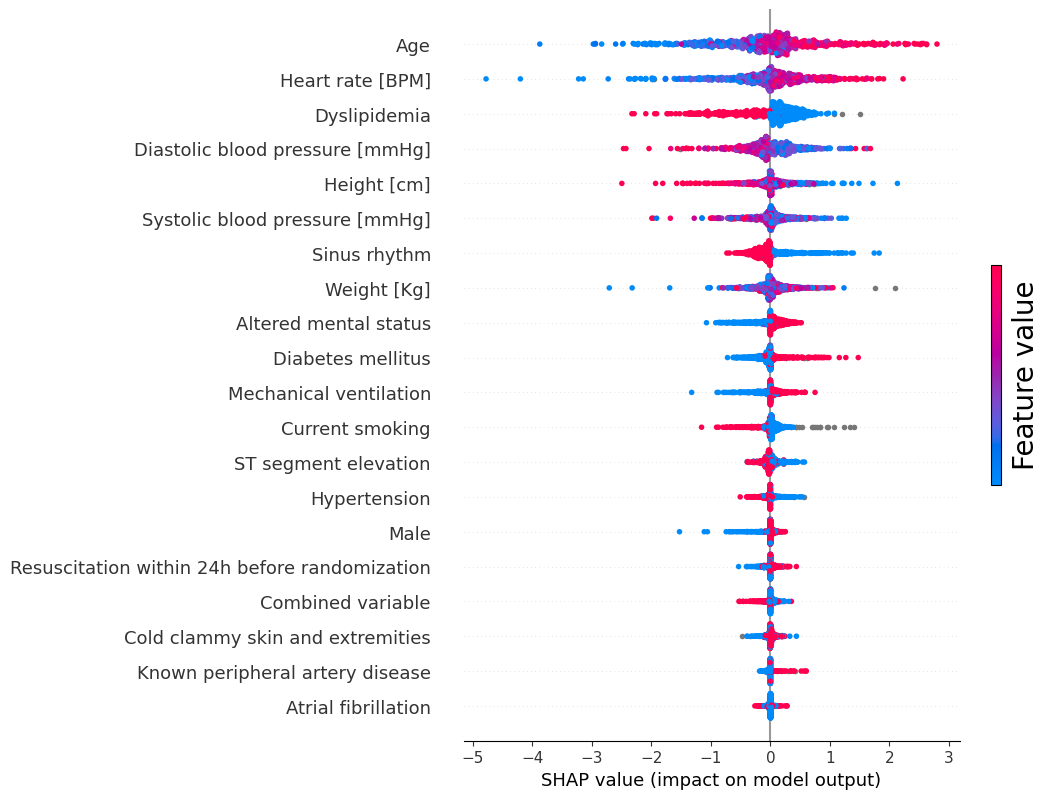

In [38]:
# beeswarm
SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
shap.plots.beeswarm(shap_values, color_bar=False, max_display=50, show=False)
plt.colorbar(location="right",label="Feature value", ticks=[], shrink=0.3)

## 24hs model

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


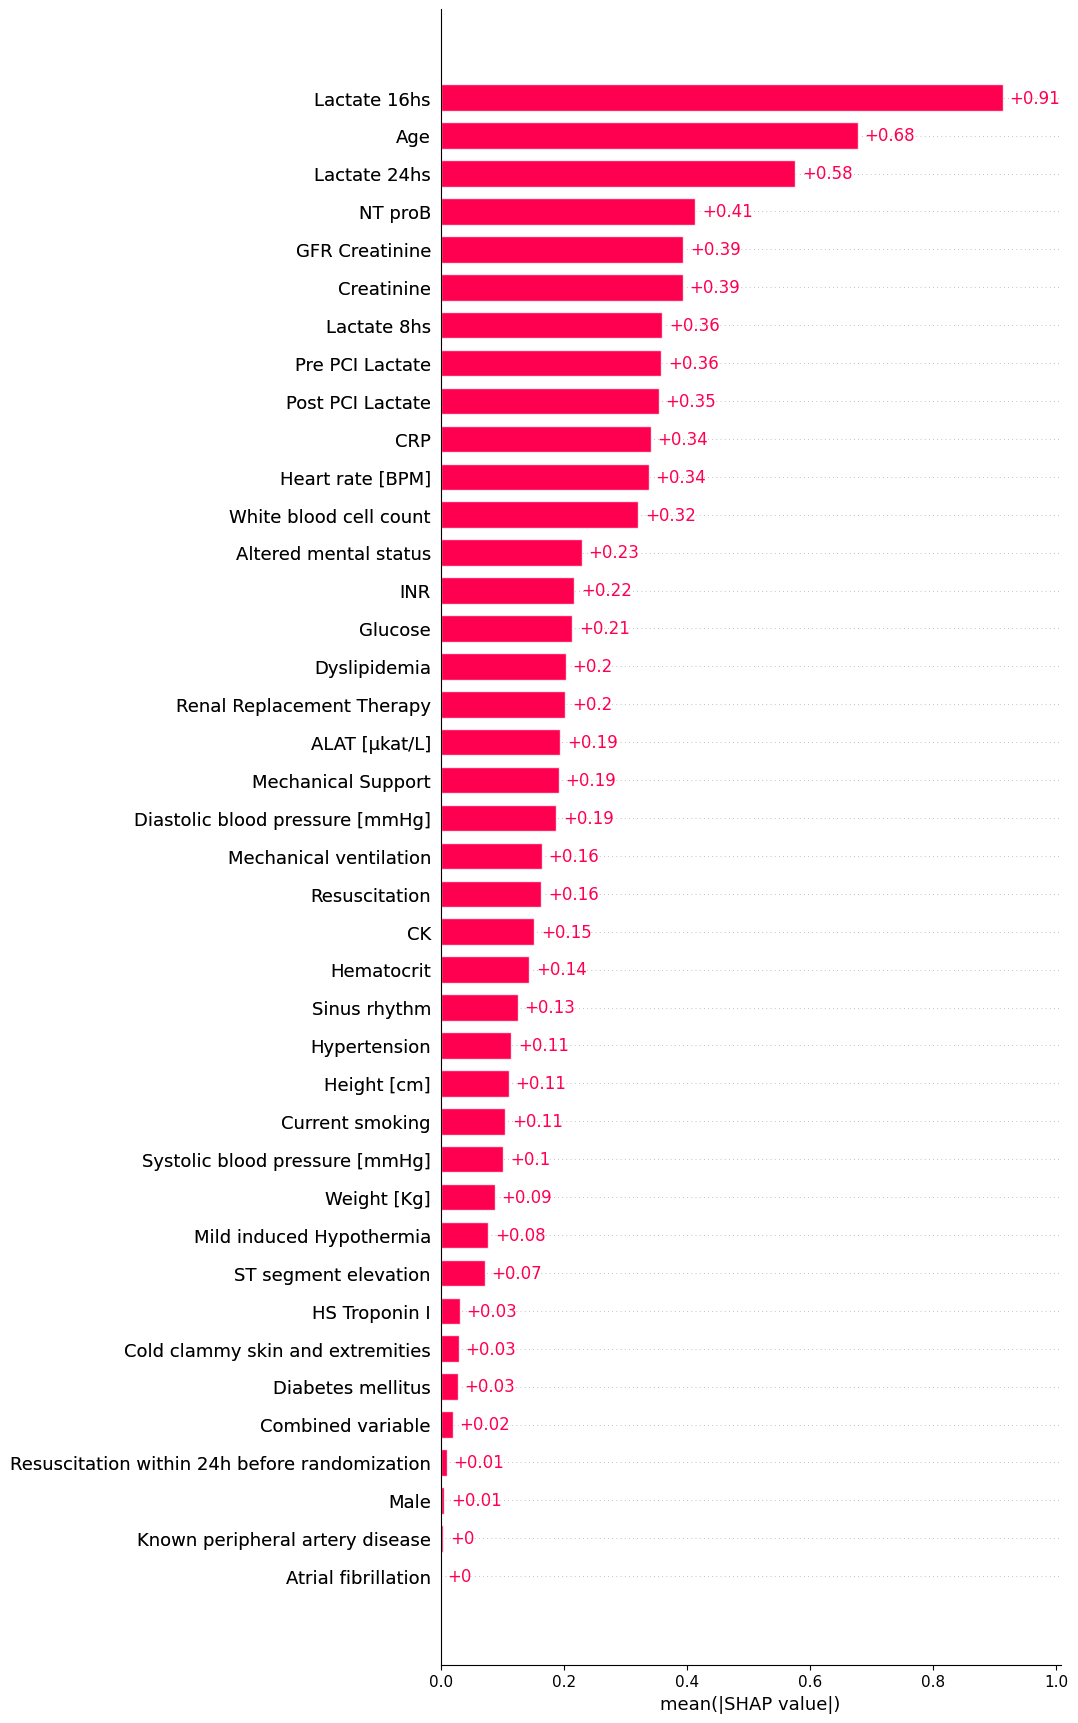

In [39]:
X_24 = pd.read_csv(data_dir+"X_24hs_high_variance.csv",index_col=0)

X_24.rename(columns={"Age_(year)": "Age",
                    "Heart_rate_(bpm)_Hemodinamics": "Heart rate [BPM]",
                    "Diastolic_blood_pressure_(mmHg)_–_HPR":"Diastolic blood pressure [mmHg]",
                    "Height_(cm)": "Height [cm]",
                    "Weight_(kg)": "Weight [Kg]",
                    'Mechanical_ventilation':'Mechanical ventilation',
                    "Resuscitation_within_24h_before_randomization": "Resuscitation within 24h before randomization",
                    "Altered_mental_status": "Altered mental status",
                    "Cold_clammy_skin_and_extremities": "Cold clammy skin and extremities",
                    "combined_variable": "Combined variable",
                    "Previous_congestive_heart_failure": "Previous congestive heart failure",
                    "Previous_stroke": "Previous stroke",
                    "Known_peripheral_artery_disease": "Known peripheral artery disease",
                    "Known_renal_insufficiency_(GFR_less_30_ml/min)": "Known renal insufficiency",
                    "Chronic_dialysis":"Chronic dialysis",
                    "Current_smoking": "Current smoking",
                    "Diabetes_mellitus": "Diabetes mellitus",
                    "Sinus_rhythm": "Sinus rhythm",
                    "Atrial_fibrillation": "Atrial fibrillation",
                    "AV-block_III": "AV block III",
                    'ST-segment_elevation':'ST segment elevation',
                    'Systolic_blood_pressure_(mmHg)_–_HPR':'Systolic blood pressure [mmHg]',
                    "Mechanical_Support":"Mechanical Support",
                    "Mild_induced_Hypothermia":"Mild induced Hypothermia",
                    "Renal_Replacement_Therapy":"Renal Replacement Therapy",
                    "Pre_PCI_Serum_lactate_value": "Pre PCI Lactate",
                    "Post_PCI_Serum_lactate_value": "Post PCI Lactate",
                    "Serum_lactate_value_8": "Lactate 8hs",
                    "Serum_lactate_value_16": "Lactate 16hs",
                    "Serum_lactate_value_24": "Lactate 24hs",
                    "No_reflow": "No reflow",
                    "Hematocrit_in_%": "Hematocrit",
                    "White_blood_cell_count_in_Gpt/L": "White blood cell count",
                    "HS_Troponin_I": "HS Troponin I",
                    "Procedural_success_(TIMI3_or_successful_complete_revascularization)": "Procedural success",
                    "ALAT_in_µkat/l": "ALAT [µkat/L]",
                    "GFR_CKD-EPI_creatinine_equation_V1_in_ml/min/1.73m²": "GFR Creatinine",
                    "NT_pro_B-type_natriuretic_peptide_V1_in_pg/ml": "NT proB"}, inplace=True)


model = joblib.load(data_dir+"model_24hs_shap_values_high_variance.pkl")

explainer = shap.Explainer(model)
shap_values = explainer(X_24)

shap_values.values = shap_dict["shap_24hs_values"]
shap_values.baseline = shap_dict["shap_24hs_baseline"]
shap_values.data = shap_dict["shap_24hs_data"]
shap.plots.bar(shap_values, max_display=50)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


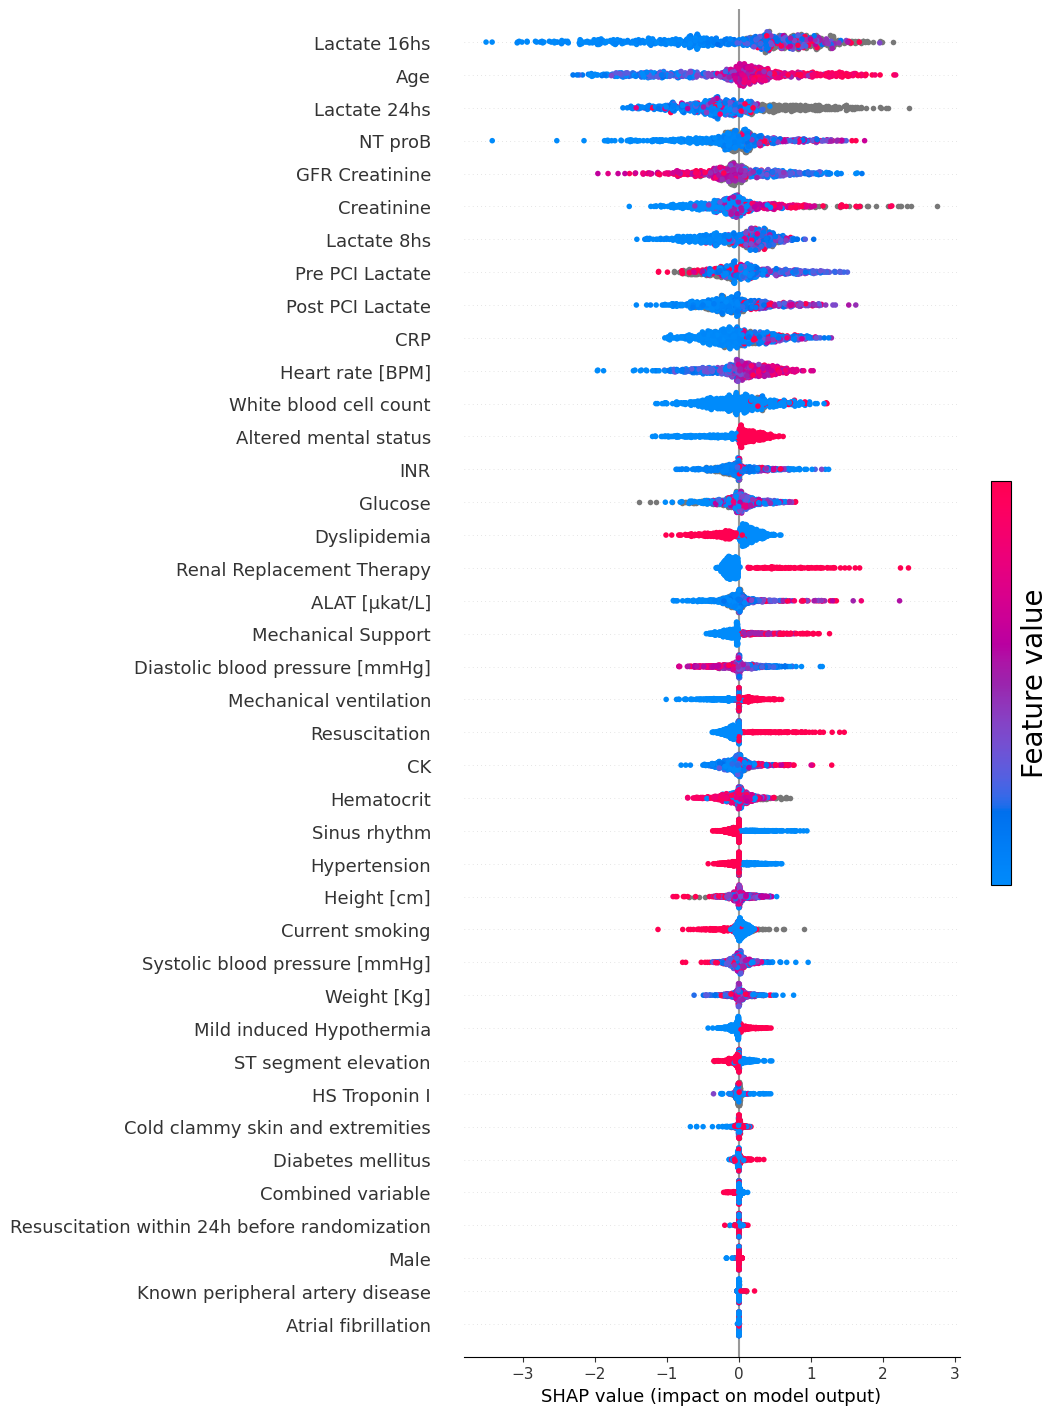

In [40]:
shap.plots.beeswarm(shap_values, color_bar=False, max_display=50,show=False)
plt.colorbar(location="right",label="Feature value", ticks=[], shrink=0.3)

# Calibration

# Admission model

(0.0, 1.0)

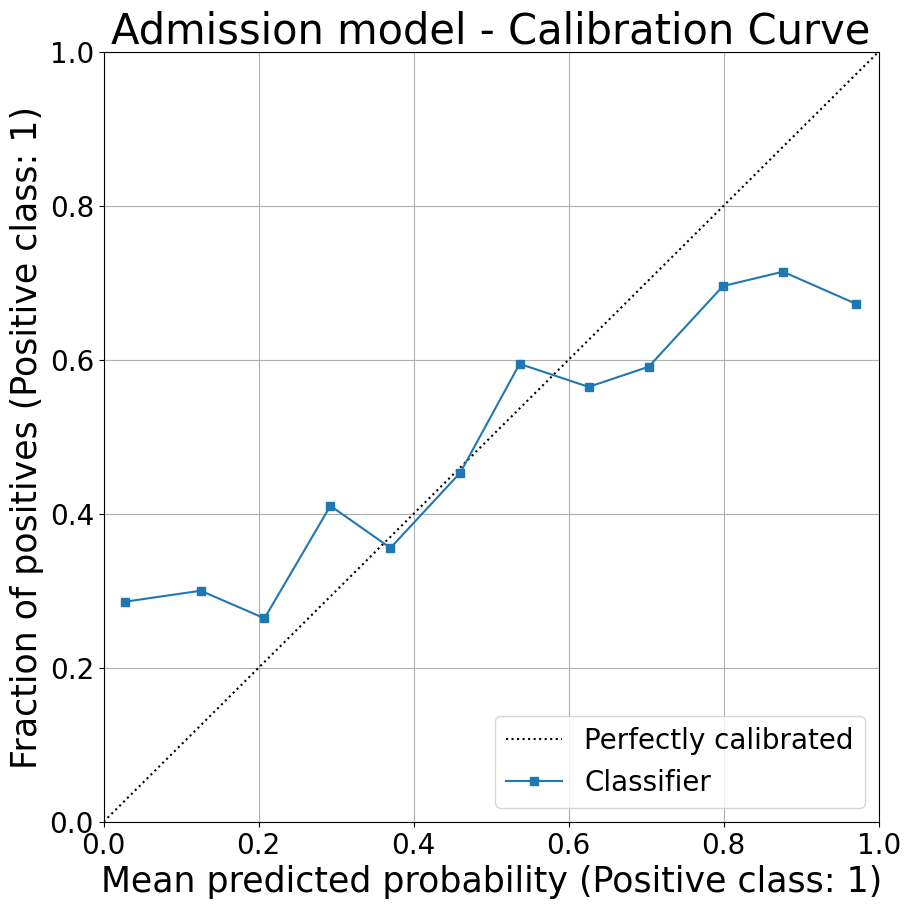

In [180]:

data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/calibration/"
load_list = ["admission_predictions_cv",
             "24hs_predictions_cv",
             "true_labels"]

calibration_dict = dict()


for file_name in load_list:
    with open(data_dir+file_name, "rb") as fp:
        calibration_dict[file_name] = pickle.load(fp)

n_bins = 12

fig, ax = plt.subplots(1, 1, figsize=[10, 10])
CalibrationDisplay.from_predictions(calibration_dict["true_labels"],
                                    calibration_dict["admission_predictions_cv"],
                                    n_bins=n_bins, ax=ax)
plt.title("Admission model - Calibration Curve")
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])

# 24hs model

(0.0, 1.0)

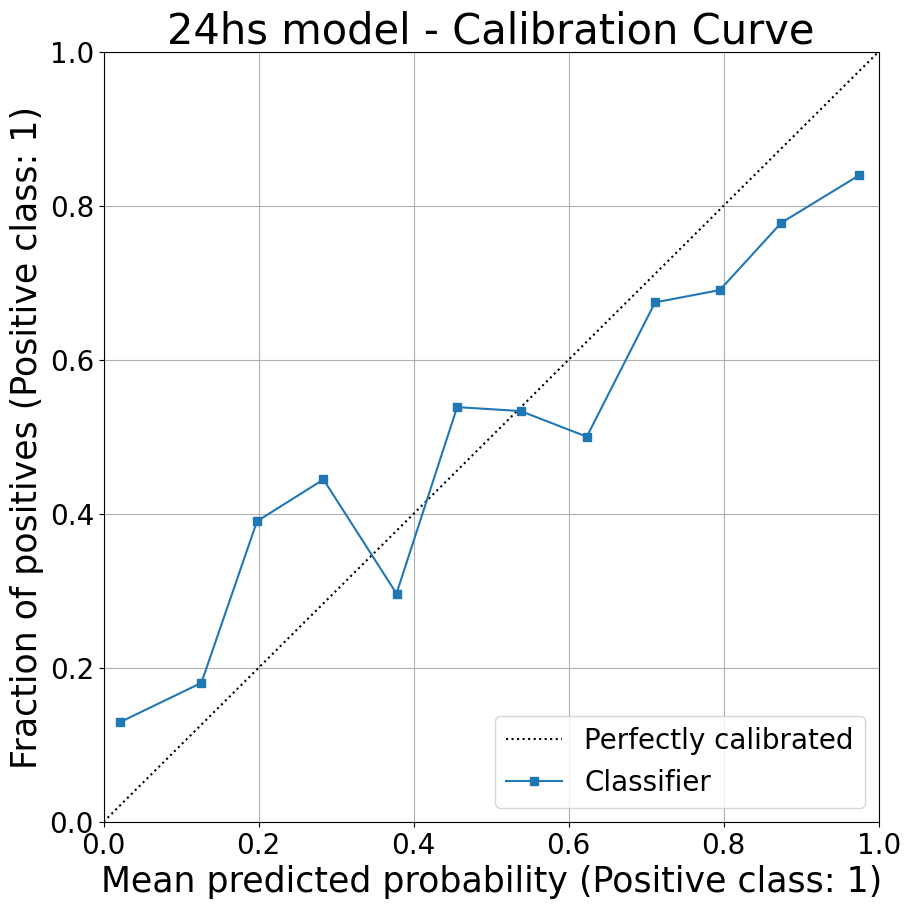

In [181]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])

CalibrationDisplay.from_predictions(calibration_dict["true_labels"],
                                    calibration_dict["24hs_predictions_cv"],
                                    n_bins=n_bins, ax=ax)
plt.title("24hs model - Calibration Curve")
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])

# Matching Cohorts

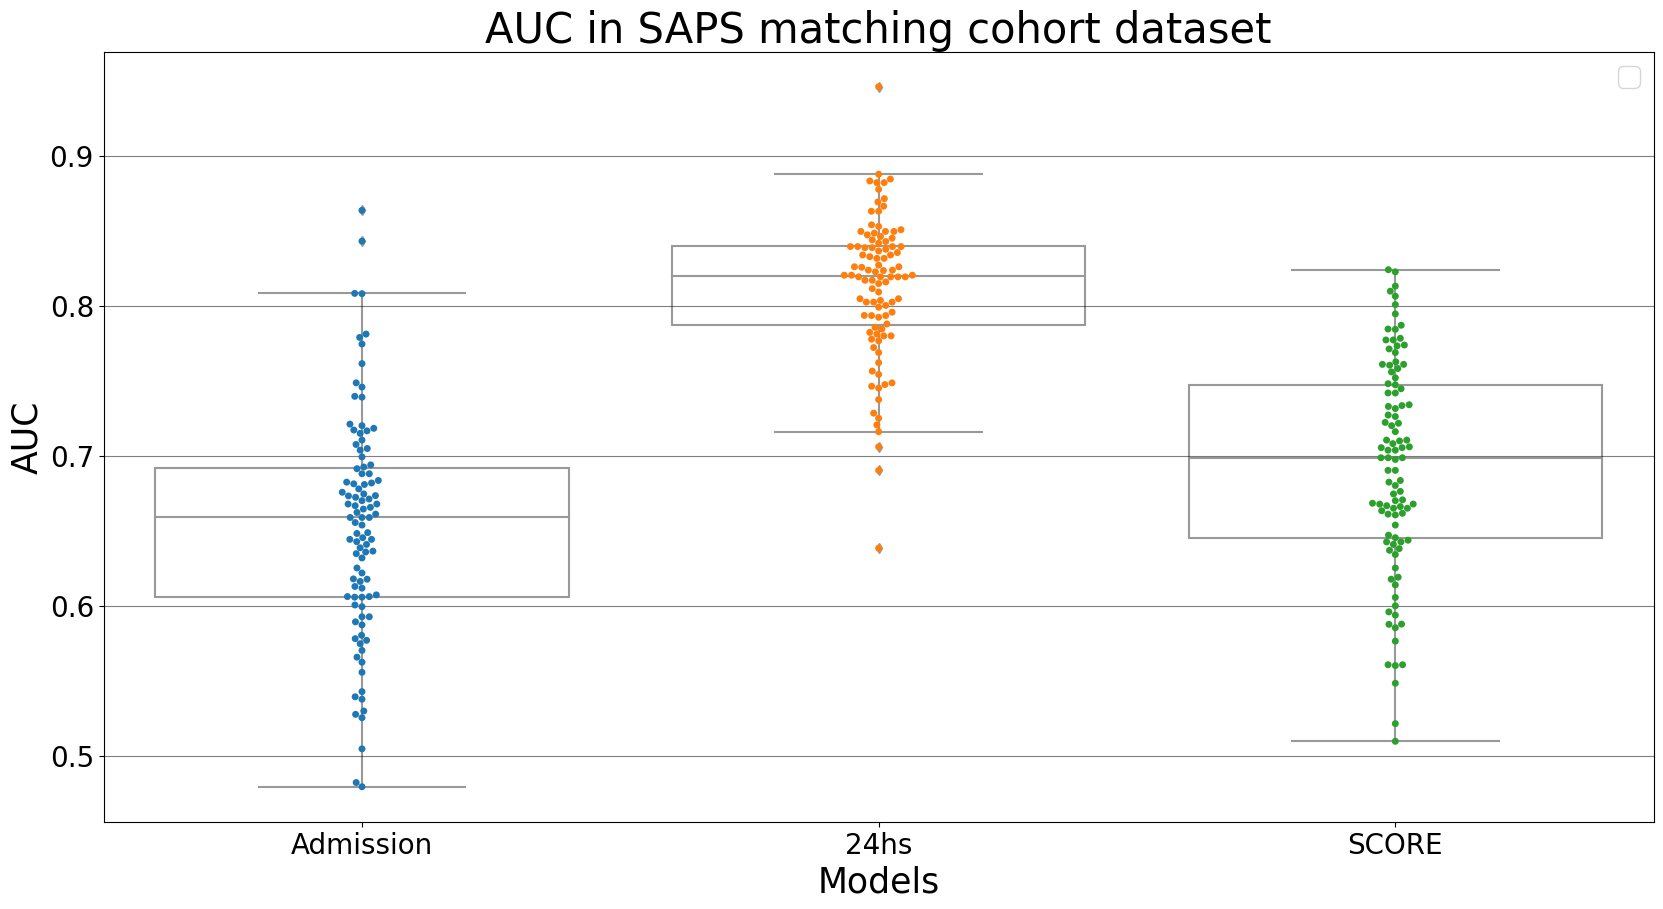

In [185]:
# Matching Cohorts
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/matching_cohors/"

score_name = "SAPS"
results_df = pd.read_csv(data_dir + "metrics_10x10_matching_cohors_"+score_name+".csv")

# Change Naming
results_df["Model"].replace({"Combined_only_risk_cascade": "Cascade Risk", "Combined_only_norisk_cascade": "Cascade No Risk"}, inplace=True)
results_df["Model"].replace({"SAPS_SCORE": "SAPS II SCORE",
                             "CLIP_SCORE": "CLIP SCORE",
                             "24hs_CLIP": "24hs + CLIP SCORE",
                             "IABP_SCORE": "IABP II SCORE"}, inplace=True)

results_true_label = results_df[results_df["Random State"]== False]

metric_to_plot = "AUC"

models_to_plot = [
                "Admission",
                  "24hs",
                  "SCORE"
                  ]

filtered_df = results_true_label[results_true_label['Model'].isin(models_to_plot)]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])

n_models = results_true_label["Model"].nunique()

sns.swarmplot(
    data=filtered_df,
    x="Model", y=metric_to_plot,
    order=models_to_plot, 
    dodge=False, hue="Model", ax=ax,
)

sns.boxplot(
    data=filtered_df, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    order=models_to_plot,
    dodge=True, ax=ax, palette=["w"]*n_models
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:models_to_plot.__len__()], labels[:models_to_plot.__len__()])
ax.legend([])

plt.ylabel(metric_to_plot)
plt.xlabel("Models")
plt.title(metric_to_plot + " in "+score_name+" matching cohort dataset")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

In [183]:
models_to_plot = ["Admission",
                  "24hs", "SCORE"]

metrics = ["Balanced ACC",
           "AUC",
           "F1",
           "Specificity",
           "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(results_true_label[results_true_label["Model"] == model][metric].mean(),3)
        results_std = round(results_true_label[results_true_label["Model"] == model][metric].std(),3)
        confidence_interval = stats.t.interval(0.95, len(results_true_label[results_true_label["Model"] == model][metric]) - 1, loc=results_mean, scale=results_std)

        print(metric + ": " + str(results_mean) + " ["+ str(round(confidence_interval[0],3)) + "/" + str(round(confidence_interval[1],3))+"]")


Admission
Balanced ACC: 0.614 [0.469/0.759]
AUC: 0.658 [0.497/0.819]
F1: 0.569 [0.375/0.763]
Specificity: 0.66 [0.473/0.847]
Sensitivity: 0.568 [0.302/0.834]
24hs
Balanced ACC: 0.719 [0.584/0.854]
AUC: 0.797 [0.662/0.932]
F1: 0.691 [0.536/0.846]
Specificity: 0.749 [0.574/0.924]
Sensitivity: 0.69 [0.474/0.906]
SCORE
Balanced ACC: 0.725 [0.596/0.854]
AUC: 0.807 [0.674/0.94]
F1: 0.672 [0.499/0.845]
Specificity: 0.847 [0.7/0.994]
Sensitivity: 0.603 [0.383/0.823]


# AUC PLOT

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
root_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/predictions/"
y_true_all = pd.read_csv(root_dir+"y_true_for_AUC.csv", index_col=0)
num_folds = 100
method_names = ["Admission", "24hs", "SAPS", "CLIP"]
method_names = ["24hs"]

import seaborn as sbn
for method_name in method_names:
    plt.figure(figsize=(10, 13))

    y_pred_24 = pd.read_csv(root_dir+method_name+"_predictions_for_AUC_high_variance.csv", index_col=0)
    melted_df = pd.melt(y_pred_24, var_name='Column', value_name='Value')
    melted_df_true = pd.melt(y_true_all, var_name='Column', value_name='Value')
    melted_df["true"] = melted_df_true["Value"]
    melted_df.dropna(inplace=True)
    sbn.swarmplot(data=melted_df, y="true")

    # Plot the chance level line
    # plt.plot([0, 1], [0.49999, 0.5000001], 'k--', lw=2, label='Chance Level')

    # Add labels and legend
    plt.grid(True)
    plt.ylim([0,1])
    # plt.xlim([-1,100])

/home/nnieto/Nico/MODS_project/Heart_env/lib/python3.9/site-packages/seaborn/categorical.py:3540: UserWarning: 77.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Error in callback <function _draw_all_if_interactive at 0x7fcf56cf1af0> (for post_execute):


In [24]:
y_pred_24 = pd.read_csv(root_dir+method_name+"_predictions_for_AUC_high_variance.csv", index_col=0)
melted_df = pd.melt(y_pred_24, var_name='Column', value_name='Value')
melted_df_true = pd.melt(y_true_all, var_name='Column', value_name='Value')
melted_df["true"] = melted_df_true["Value"]
melted_df.dropna(inplace=True)
sbn.swarmplot(data=melted_df, x="true")


KeyboardInterrupt: 

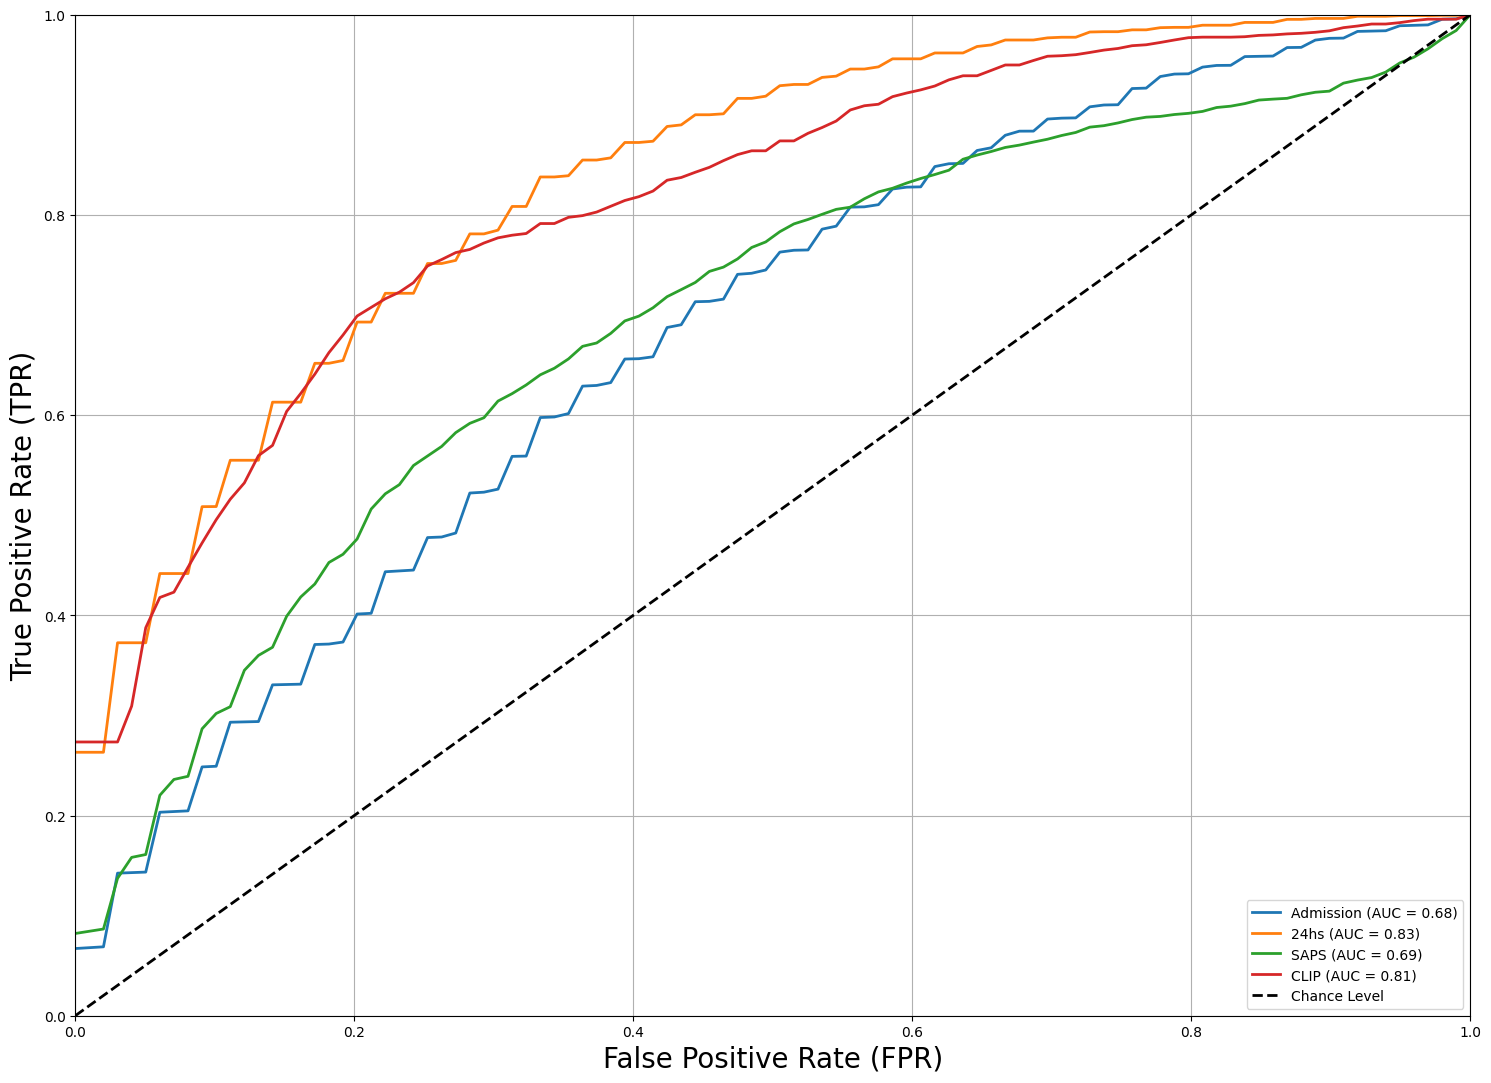

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
root_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/predictions/"
y_true_all = pd.read_csv(root_dir+"y_true_for_AUC.csv", index_col=0)
num_folds = 100
method_names = ["Admission", "24hs", "SAPS", "CLIP"]
all_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(18, 13))

for method_name in method_names:
    y_pred_24 = pd.read_csv(root_dir+method_name+"_predictions_for_AUC_high_variance.csv", index_col=0)

    if method_name in ["SAPS", "CLIP"]:
        y_true_all = pd.read_csv(root_dir+"y_true_"+method_name+"_for_AUC.csv", index_col=0)
    else:
        y_true_all = pd.read_csv(root_dir+"y_true_for_AUC.csv", index_col=0)

    # Initialize arrays to store accumulated TPR and FPR values
    mean_tpr = 0

    # Iterate through the folds for the current method
    for fold in y_true_all.columns:
        y_pred = y_pred_24.loc[:,str(fold)]
        y_pred.dropna(inplace=True)
        y_true = y_true_all.loc[:,str(fold)]
        y_true.dropna(inplace=True)

        # Calculate ROC curve for the current fold
        fpr, tpr, _ = roc_curve(y_true, y_pred)

        # Interpolate the TPR values to match the all_fpr values
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    # Calculate the mean TPR across all folds for the current method
    mean_tpr /= num_folds

    # Calculate the AUC for the average ROC curve of the current method
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot the average ROC curve for the current method
    plt.plot(all_fpr, mean_tpr, lw=2, label=f'{method_name} (AUC = {mean_auc:.2f})')


# Plot the chance level line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance Level')

# Add labels and legend
# plt.title('Average ROC Curve across Folds')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Show the plot
plt.show()

In [55]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
results_ths_df = pd.read_csv(data_dir + "threshold_10x10_all_models.csv")

results_ths_df.head()

,Unnamed: 0,Fold,Model,Threshold,Balanced ACC,AUC,F1,Specificity,Sensitivity
0,0,0,Admission,0.00,0.500000,0.637669,0.633663,0.000000,1.00000
1,1,0,Admission,0.01,0.551943,0.637669,0.652632,0.135135,0.96875
2,2,0,Admission,0.02,0.534206,0.637669,0.630435,0.162162,0.90625
3,3,0,Admission,0.03,0.534206,0.637669,0.630435,0.162162,0.90625
4,4,0,Admission,0.04,0.534206,0.637669,0.630435,0.162162,0.90625


The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f4479aaabe0> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f4479a6a220> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f4479a715b0> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f4479a79580> starts with '_'. It is thus excluded from the legend.


([<matplotlib.axis.XTick at 0x7f4479b7e160>,
 [Text(0.0, 0, '0.00'),
  Text(0.05, 0, '0.05'),
  Text(0.1, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20'),
  Text(0.25, 0, '0.25'),
  Text(0.30000000000000004, 0, '0.30'),
  Text(0.35000000000000003, 0, '0.35'),
  Text(0.4, 0, '0.40'),
  Text(0.45, 0, '0.45'),
  Text(0.5, 0, '0.50'),
  Text(0.55, 0, '0.55'),
  Text(0.6000000000000001, 0, '0.60'),
  Text(0.65, 0, '0.65'),
  Text(0.7000000000000001, 0, '0.70'),
  Text(0.75, 0, '0.75'),
  Text(0.8, 0, '0.80'),
  Text(0.8500000000000001, 0, '0.85'),
  Text(0.9, 0, '0.90'),
  Text(0.9500000000000001, 0, '0.95'),
  Text(1.0, 0, '1.00')])

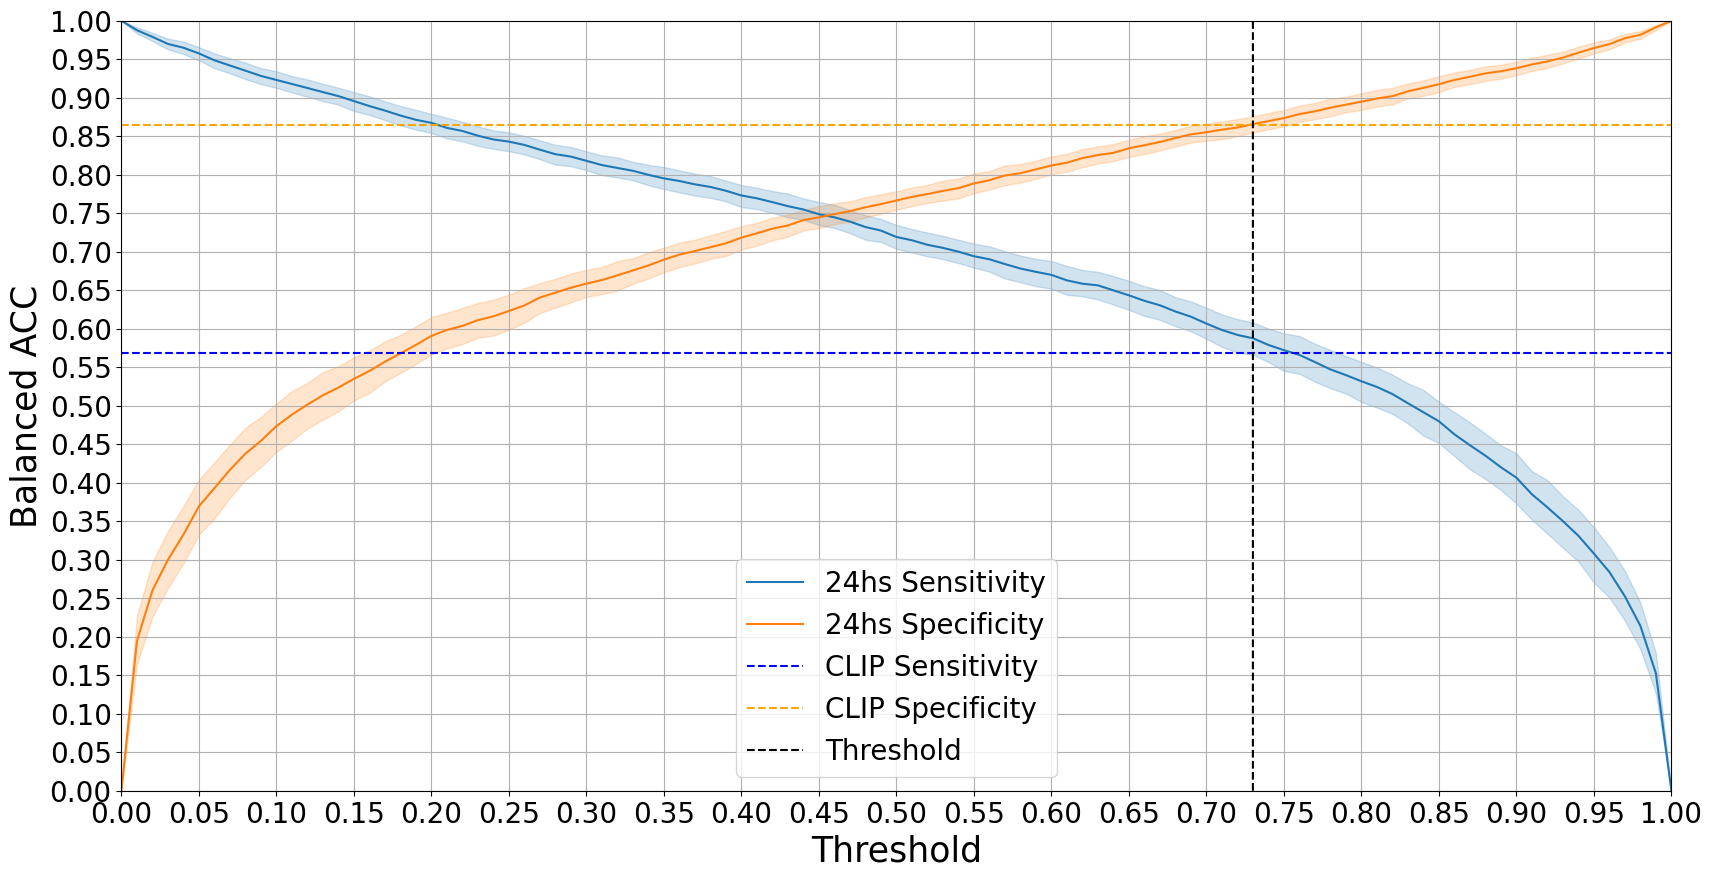

In [9]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"
results_ths_df = pd.read_csv(data_dir + "threshold_10x10_all_models.csv")


fig, ax = plt.subplots(1, 1, figsize=[20, 10])
model_to_plot = "24hs"
results_ths_df_to_plot = results_ths_df[results_ths_df["Model"] == model_to_plot]   
sns.lineplot(data=results_ths_df_to_plot, y="Sensitivity", x="Threshold", legend=True, ax=ax)
sns.lineplot(data=results_ths_df_to_plot, y="Specificity", x="Threshold", legend=True, ax=ax)


model_to_compare = "CLIP SCORE"
model_sensitivity = results_true_label[results_true_label["Model"] == model_to_compare]["Sensitivity"].mean()
model_specificity = results_true_label[results_true_label["Model"] == model_to_compare]["Specificity"].mean()
sns.lineplot(
    x=[0, 1], y=[model_sensitivity,                                                         
                 model_sensitivity], ax=ax, color="blue", linestyle="--", legend=True)
sns.lineplot(

    x=[0, 1], y=[model_specificity,                                                          
                 model_specificity], ax=ax, color="orange", linestyle="--", legend=True)

plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel(metric_to_plot)
model_specificity = 0.73
sns.lineplot(
    x=[model_specificity-0.00001,  model_specificity], y=[0, 1], ax=ax, color="black", linestyle="--", legend=True)

plt.legend(["24hs Sensitivity","_none", "24hs Specificity", "_none",
            "CLIP Sensitivity","_none", "CLIP Specificity", "_none", "Threshold"])
custom_ticks = np.arange(0, 1.01, 0.05)  # Range from 0 to 1 with step of 0.1
plt.yticks(custom_ticks)
plt.xticks(custom_ticks)
# plt.title("24hs and CLIP score Sensitivity-Specificity analysis")

In [7]:
model_to_plot = "24hs"
results_ths_df_to_plot = results_ths_df[results_ths_df["Model"] == model_to_plot]  
results_ths_df_to_plot.iloc[5095,:]
results_ths_df_to_plot_senti = results_ths_df_to_plot[results_ths_df_to_plot["Specificity"] == results_ths_df_to_plot.iloc[5095,:]["Specificity"]]  
print("mean: "+ str(results_ths_df_to_plot_senti["Sensitivity"].mean()))
print("std: "+ str(results_ths_df_to_plot_senti["Sensitivity"].std()))


mean: 0.5821759259259259
std: 0.13886759532787102


In [ ]:
model_to_plot = "24hs"
results_ths_df_to_plot = results_ths_df[results_ths_df["Model"] == model_to_plot]  
results_ths_df_to_plot.iloc[5095,:]
results_ths_df_to_plot_senti = results_ths_df_to_plot[results_ths_df_to_plot["Specificity"] == results_ths_df_to_plot.iloc[5095,:]["Specificity"]]  


# Admission v2

In [4]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/"

results_df = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels_admission_v2.csv", index_col=0)
results_true_label = results_df[results_df["Random State"]== False]


models_to_plot = ["Admission",
                #   "24hs",
                #   "SAPS II SCORE",
                #   "CLIP SCORE", 
                  ]

metrics = ["Balanced ACC",
           "AUC",
           "F1",
           "Specificity",
           "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(results_true_label[results_true_label["Model"] == model][metric].mean(),3)
        results_std = round(results_true_label[results_true_label["Model"] == model][metric].std(),3)
        print(metric + ": " + str(results_mean) + " +- " + str(results_std))
        confidence_interval = stats.t.interval(0.95, len(results_true_label[results_true_label["Model"] == model][metric]) - 1, loc=results_mean, scale=results_std)
        print("95% Confidence Interval: [", str(round(confidence_interval[0],3)) + "-" + str(round(confidence_interval[1],3))+"]")


Admission
Balanced ACC: 0.63 +- 0.055
95% Confidence Interval: [ 0.521-0.739]
AUC: 0.678 +- 0.06
95% Confidence Interval: [ 0.559-0.797]
F1: 0.609 +- 0.063
95% Confidence Interval: [ 0.484-0.734]
Specificity: 0.652 +- 0.073
95% Confidence Interval: [ 0.507-0.797]
Sensitivity: 0.609 +- 0.081
95% Confidence Interval: [ 0.448-0.77]


# V2

In [3]:
results_24hs =pd.read_csv("/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/v2/metrics_10x10_true_and_random_labels_24hs_v2.csv", index_col=0)

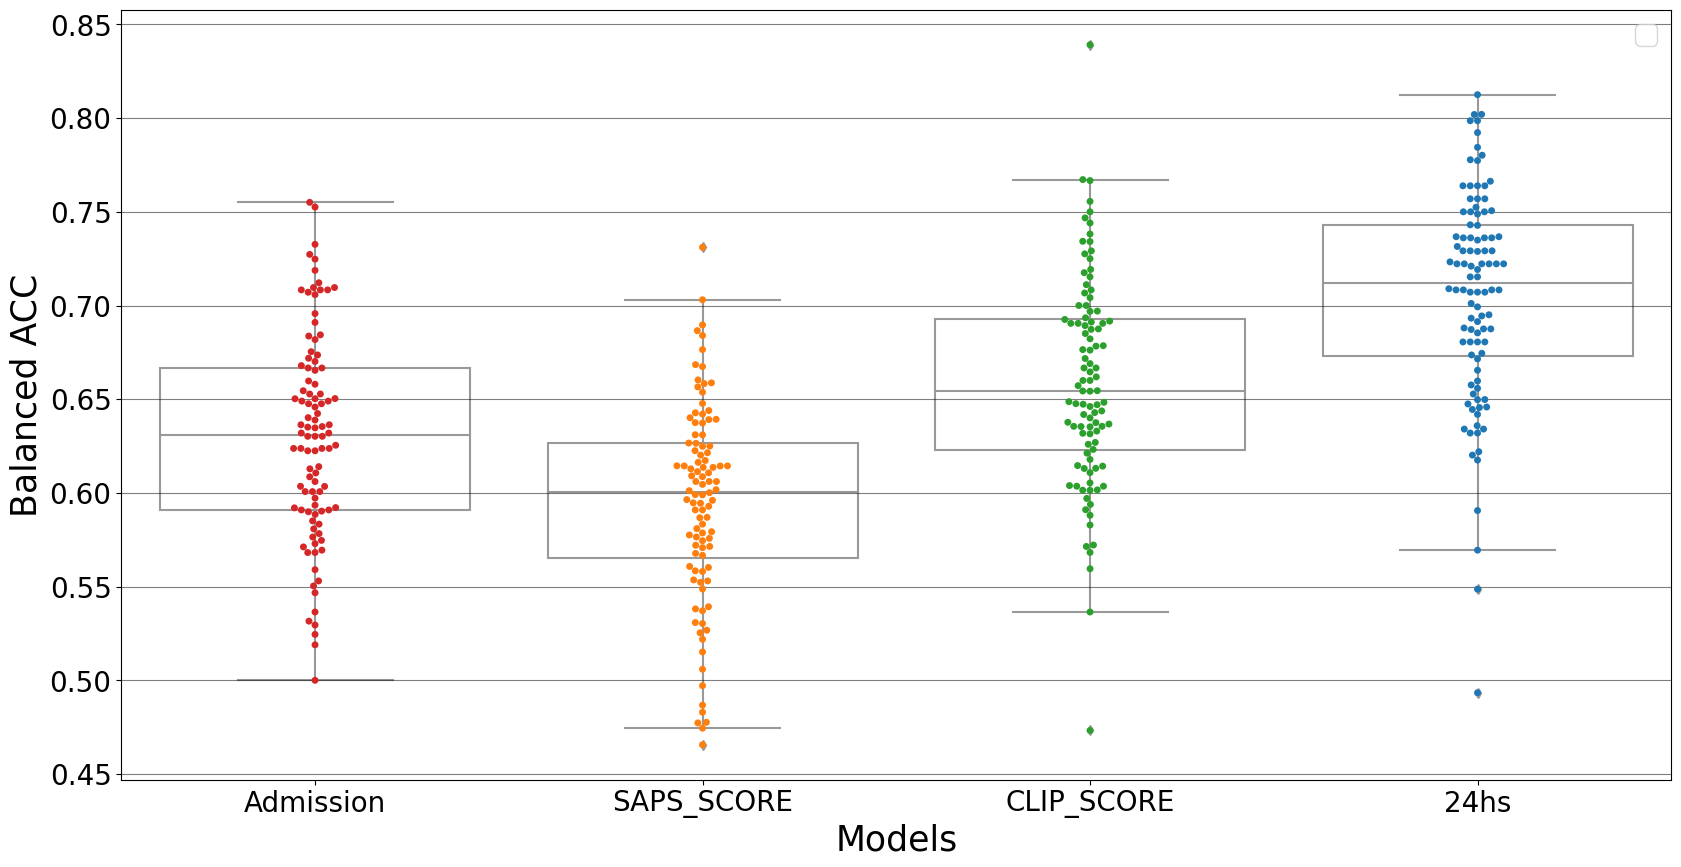

In [20]:
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/v2/"
results_24hs = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_24hs_v2.csv")
results_scores = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_scores_v2.csv")
results_admission = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_admission_v2.csv")

results = pd.concat([results_24hs, results_scores, results_admission])

results_true_label = results[results["Random State"]== False]

metric_to_plot = "Balanced ACC"

models_to_plot = ["Admission",
                  "SAPS_SCORE",
                  "CLIP_SCORE",
                  "24hs"]

filtered_df = results_true_label[results_true_label['Model'].isin(models_to_plot)]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])

n_models = results_true_label["Model"].nunique()

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


sns.swarmplot(
    data=filtered_df,
    x="Model", y=metric_to_plot,
    order=models_to_plot, 
    dodge=False, hue="Model", ax=ax,
)

sns.boxplot(
    data=filtered_df, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    order=models_to_plot,
    dodge=True, ax=ax, palette=["w"]*n_models
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:models_to_plot.__len__()], labels[:models_to_plot.__len__()])
ax.legend([])

plt.ylabel(metric_to_plot)
plt.xlabel("Models")
# plt.title(metric_to_plot + " in CULPRIT dataset")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

In [21]:
results_true_label = results[results["Random State"]== False]


models_to_plot = ["Admission",
                  "SAPS_SCORE",
                  "CLIP_SCORE",
                  "24hs"]
metrics = ["Balanced ACC",
           "AUC",
           "F1",
           "Specificity",
           "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(results_true_label[results_true_label["Model"] == model][metric].mean(),3)
        results_std = round(results_true_label[results_true_label["Model"] == model][metric].std(),3)
        print(metric + ": " + str(results_mean) + " +- " + str(results_std))
        confidence_interval = stats.t.interval(0.95, len(results_true_label[results_true_label["Model"] == model][metric]) - 1, loc=results_mean, scale=results_std)
        print("95% Confidence Interval: [", str(round(confidence_interval[0],3)) + "-" + str(round(confidence_interval[1],3))+"]")


Admission
Balanced ACC: 0.63 +- 0.055
95% Confidence Interval: [ 0.521-0.739]
AUC: 0.678 +- 0.06
95% Confidence Interval: [ 0.559-0.797]
F1: 0.608 +- 0.064
95% Confidence Interval: [ 0.481-0.735]
Specificity: 0.654 +- 0.072
95% Confidence Interval: [ 0.511-0.797]
Sensitivity: 0.606 +- 0.081
95% Confidence Interval: [ 0.445-0.767]
SAPS_SCORE
Balanced ACC: 0.595 +- 0.053
95% Confidence Interval: [ 0.49-0.7]
AUC: 0.677 +- 0.071
95% Confidence Interval: [ 0.536-0.818]
F1: 0.417 +- 0.105
95% Confidence Interval: [ 0.209-0.625]
Specificity: 0.859 +- 0.063
95% Confidence Interval: [ 0.734-0.984]
Sensitivity: 0.33 +- 0.106
95% Confidence Interval: [ 0.12-0.54]
CLIP_SCORE
Balanced ACC: 0.659 +- 0.056
95% Confidence Interval: [ 0.548-0.77]
AUC: 0.794 +- 0.071
95% Confidence Interval: [ 0.653-0.935]
F1: 0.525 +- 0.102
95% Confidence Interval: [ 0.323-0.727]
Specificity: 0.9 +- 0.054
95% Confidence Interval: [ 0.793-1.007]
Sensitivity: 0.418 +- 0.11
95% Confidence Interval: [ 0.2-0.636]
24hs
Balan